In [1]:
#import os
import sqlite3
from datetime import datetime
import warnings
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
#from matplotlib.colors import LinearSegmentedColormap
#from matplotlib import colors as mcolors
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster import hierarchy
from statsmodels.nonparametric.kernel_regression import KernelReg


# Suppression warnings KMeans
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.')
warnings.filterwarnings(action='ignore', 
                        message='KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.')
warnings.filterwarnings(action='ignore', 
                        message = 'DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()')


# Liste des fonctions

def f_requete_sql (requete) :
    try:
        connexion = sqlite3.connect('../data/liste_piezos.db')
        curseur = connexion.cursor()
        print("Connexion réussie à SQLite")
        curseur.execute(requete)
        connexion.commit()
        resultat = curseur.fetchall()
        curseur.close()
        connexion.close()
        print("Connexion SQLite est fermée")
        return resultat
    except sqlite3.Error as error:
        print("Erreur lors du mis à jour dans la table", error)

        
def scaleColumns(df):
    for col in df.columns:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col], index=df.index)
    return df        


def f_clusters_transform (df):
    """
    df : dataframe pandas
    """
    data = df.values.T
    names = df.columns
    return(data, names)



def f_clusters_coude (df, n_init:int=100, plage:tuple = (2,20)) :
    """
    df : dataframe à entrer
    n_init : nombre de configuration de départ pour les centroïdes
    plage : plage de mesure du k optimal
    """   
    
    # Transformation du dataframe d'entrée pour analyse
    data, names = f_clusters_transform(df)

    if plage[1] > data.shape[0]:
        plage[1] = data.shape[0]

    k_mesure = range(plage[0], plage[1])

    results = pd.DataFrame(index=k_mesure, columns=["inertia"], dtype='float')

    for k in tqdm (k_mesure,
                    desc="Calcul de l'inertie",  
                    ascii=False, ncols=100) :
        km = KMeans(n_clusters=k, n_init=n_init) 
        km = km.fit(data)
        inertie = km.inertia_
        results.loc[k,"inertia"] = inertie

        
    # Calcul des dérivées premières et secondes.
    # yb - ya / xb - xa
    # On prend en compte la pente de la droite qui suit le point en quaestion
    results["deriv"] = np.NaN
    for k in results.index.values:
        try : 
            results.loc[k, "deriv"] = results.loc[k+1, "inertia"] - results.loc[k, "inertia"]
        except:
            pass

    results["deriv_2"] = np.NaN
    for k in results.index.values:
        try : 
            results.loc[k, "deriv_2"] = results.loc[k+1, "deriv"] - results.loc[k, "deriv"]
        except:
            pass

    median = results.loc[10:,"deriv_2"].quantile(0.5)
    Q1 = results.loc[10:,"deriv_2"].quantile(0.25)
    Q3 = results.loc[10:,"deriv_2"].quantile(0.75)
    
    mean = results.loc[10:,"deriv_2"].mean()
    sigma = results.loc[10:,"deriv_2"].std()
      
    best_k = results[results.deriv_2 < (mean + 2*sigma)].first_valid_index()
        
        
    fig, ax1 = plt.subplots(figsize=(12,8))

    fig.suptitle(f"Nombre de cluster optimal estimé : {best_k}")

    ax1.plot(results.inertia)
    ax1.set_xlabel('nombre de clusters')
    ax1.set_ylabel('inertie')
    ax1.legend(["inertie"], bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax1.scatter(best_k, results.loc[best_k,"inertia"],s=100, c='red', marker='X')
    ax1.axvline(x=best_k, color='gray',linestyle='--')

    ax2 = plt.axes([0,0,1,1])
    # Manually set the position and relative size of the inset axes within ax1
    ip = InsetPosition(ax1, [0.45,0.45,0.5,0.5])
    ax2.set_axes_locator(ip)
    # Mark the region corresponding to the inset axes on ax1 and draw lines
    # in grey linking the two axes.
    ax2.plot(results.deriv_2)
    ax2.set_xlabel('nombre de clusters')
    ax2.set_ylabel('dérivée 2nde')
    ax2.axvline(x=best_k, color='gray',linestyle='--')
    ax2.fill_between(np.arange(1,plage[1]), 
                     mean + 2*sigma, 
                     mean - 2*sigma, 
                     color='lightcoral')

    return best_k, results
    
    
    
def f_clusters_fit (df, k:int = 4, n_init:int = 100, max_iter:int = 2000):
    
    """
    Entrainement et affichage de la distribution dans les clusters
    return :
    - cluster_table : df bss - cluster - MSE
    - df_clusters_centers : df série temporelle des clusters
    - metric : "euclidean" / "dtw" / "softdtw"
    """
    
    data, names = f_clusters_transform(df)
    # Initilialisation du modèle
    km = KMeans(n_clusters=k, n_init=n_init, max_iter=max_iter, random_state=2022)
    # Entraînement du modèle
    km.fit(data)
    # Définition des numéros de cluster
    labels = km.labels_+1 
    # Profils des clusters
    cluster_centers = np.array(km.cluster_centers_)
    df_cluster_centers = pd.DataFrame(cluster_centers.T, index=df.index)
    for cluster in range(df_cluster_centers.shape[1]):
        df_cluster_centers.rename(columns = {cluster:f"cluster_{cluster+1}"}, inplace=True)
    
    # Création du dataframe de résultats
    cluster_table = pd.DataFrame()
    cluster_table["code_bss"] = names
    cluster_table.set_index("code_bss", inplace=True)
    cluster_table["cluster"] = labels
    for piezo in cluster_table.index :
        cluster_table.loc[piezo, "MSE"] = mean_squared_error(df.loc[:,piezo], cluster_centers[cluster_table.loc[piezo, "cluster"]-1])
    
    return cluster_table, df_cluster_centers

def f_plot_clusters (df, cluster_table, cluster_centers, plot_mean:bool = True):
    
    data, names = f_clusters_transform (df)
    
    labels = cluster_table["cluster"]
    
    fig, axs = plt.subplots(len(set(labels)),1,figsize=(20,4*cluster_centers.shape[1]))
    row_i=0

    for label in set(labels):
        for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i].plot(df.iloc[:,i],alpha=0.4)
        if plot_mean:
            axs[row_i].plot(cluster_centers.iloc[:,label-1],c="red")
        axs[row_i].set_title("Cluster "+str(row_i+1))
        row_i+=1
    plt.show()
    
def f_plot_all (df, cluster_table, df_cluster_centers) :

    if df.shape[1]%4 == 0:
        nbre_lignes = df.shape[1]//4
    else : 
        nbre_lignes = df.shape[1]//4 + 1

    fig, axs = plt.subplots(nbre_lignes,4,figsize=(25,200))
    #fig.suptitle('Series')
    for i in range(nbre_lignes):
        for j in range(4):
            if i*4+j+1>df.shape[1]: # pass the others that we can't fill
                continue
            axs[i, j].plot(df.iloc[:,i*4+j])
            axs[i, j].plot(df_cluster_centers.iloc[:,cluster_table.iloc[i*4+j,0]-1])
            
            axs[i, j].set_title(df.columns[i*4+j] + f" - MSE = {round(cluster_table.loc[df.columns[i*4+j],'MSE'],2)}")
            
    plt.show()
    

def f_MSEmax (cluster_table):
    # Calcul de MSEmin

    Q1 = cluster_table["MSE"].quantile(0.25, "higher")
    Q3 = cluster_table["MSE"].quantile(0.75, "lower")

    # Ecart inter-quartile
    IQM = abs(Q3-Q1)

    # Seuil minimal de conservation des chroniques (Q3+1.5*IQM)

    MSEmin = Q3+1.5*IQM
    return MSEmin

## Dataframe results

In [ ]:
df_resultats = pd.DataFrame()


région :  BRE  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:23<00:00,  1.54s/it]


région :  BRE  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:26<00:00,  1.79s/it]


région :  BRE  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:25<00:00,  1.68s/it]


région :  BRE  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:25<00:00,  1.72s/it]


région :  BRE  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:25<00:00,  1.72s/it]


région :  BRE  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:24<00:00,  1.61s/it]


région :  CVL  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:33<00:00,  2.22s/it]


région :  CVL  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:32<00:00,  2.18s/it]


région :  CVL  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:32<00:00,  2.14s/it]


région :  CVL  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:31<00:00,  2.12s/it]


région :  CVL  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:32<00:00,  2.18s/it]


région :  CVL  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:32<00:00,  2.14s/it]


région :  GES  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:40<00:00,  2.69s/it]


région :  GES  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:39<00:00,  2.63s/it]


région :  GES  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:40<00:00,  2.72s/it]


région :  GES  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:39<00:00,  2.67s/it]


région :  GES  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:39<00:00,  2.66s/it]


région :  GES  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:42<00:00,  2.85s/it]


région :  HDF  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:35<00:00,  2.35s/it]


région :  HDF  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:33<00:00,  2.25s/it]


région :  HDF  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:34<00:00,  2.31s/it]
/var/folders/4m/lkng0wfn70g441yq6gb_pxz00000gn/T/ipykernel_14508/333903575.py:120: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots(figsize=(12,8))


région :  HDF  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:37<00:00,  2.48s/it]


région :  HDF  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:37<00:00,  2.47s/it]


région :  HDF  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:34<00:00,  2.27s/it]


région :  IDF  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:23<00:00,  1.58s/it]


région :  IDF  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:23<00:00,  1.59s/it]


région :  IDF  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:23<00:00,  1.58s/it]


région :  IDF  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:23<00:00,  1.59s/it]


région :  IDF  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:22<00:00,  1.53s/it]


région :  IDF  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:24<00:00,  1.64s/it]


région :  NAQ  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [01:01<00:00,  4.12s/it]


région :  NAQ  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [01:02<00:00,  4.19s/it]


région :  NAQ  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [01:00<00:00,  4.02s/it]


région :  NAQ  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:59<00:00,  3.94s/it]


région :  NAQ  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [01:03<00:00,  4.20s/it]


région :  NAQ  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [01:02<00:00,  4.15s/it]


région :  NOR  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:32<00:00,  2.13s/it]


région :  NOR  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:34<00:00,  2.31s/it]


région :  NOR  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:32<00:00,  2.18s/it]


région :  NOR  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:32<00:00,  2.19s/it]


région :  NOR  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:33<00:00,  2.21s/it]


région :  NOR  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:33<00:00,  2.22s/it]


région :  OCC  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:36<00:00,  2.41s/it]


région :  OCC  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:37<00:00,  2.51s/it]


région :  OCC  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:34<00:00,  2.33s/it]


région :  OCC  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:35<00:00,  2.34s/it]


région :  OCC  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:35<00:00,  2.38s/it]


région :  OCC  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:35<00:00,  2.36s/it]


région :  PAC  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:21<00:00,  1.43s/it]


région :  PAC  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:22<00:00,  1.49s/it]


région :  PAC  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:21<00:00,  1.46s/it]


région :  PAC  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:22<00:00,  1.51s/it]


région :  PAC  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:22<00:00,  1.51s/it]


région :  PAC  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:21<00:00,  1.46s/it]


région :  PDL  - iteration :  1


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:28<00:00,  1.87s/it]


région :  PDL  - iteration :  2


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:28<00:00,  1.88s/it]


région :  PDL  - iteration :  3


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:30<00:00,  2.06s/it]


région :  PDL  - iteration :  4


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:30<00:00,  2.06s/it]


région :  PDL  - iteration :  5


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:30<00:00,  2.02s/it]


région :  PDL  - iteration :  6


Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:30<00:00,  2.03s/it]


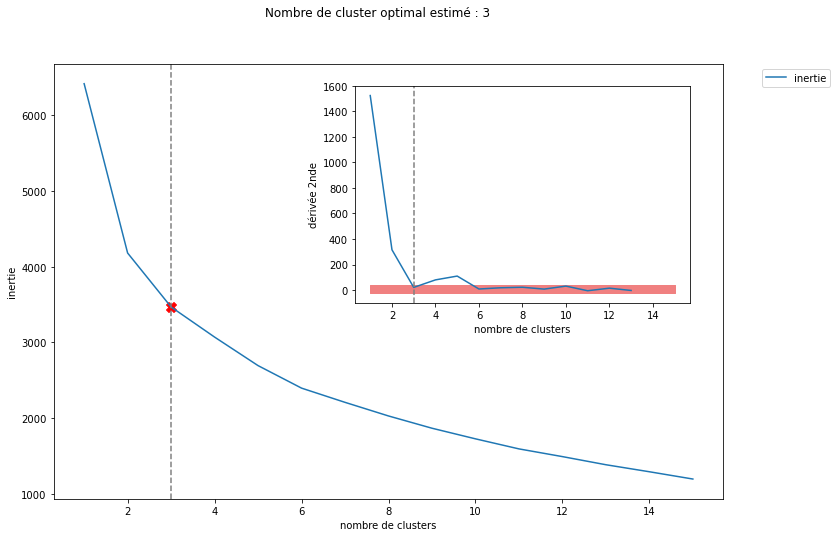

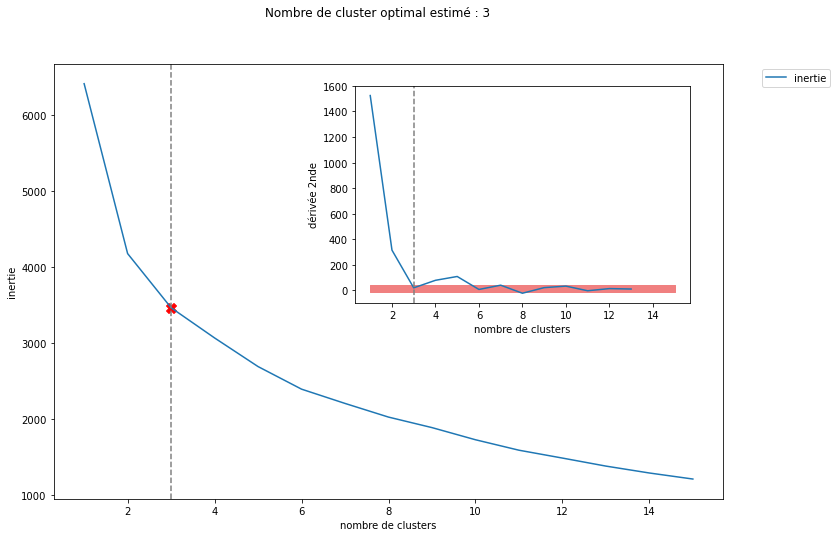

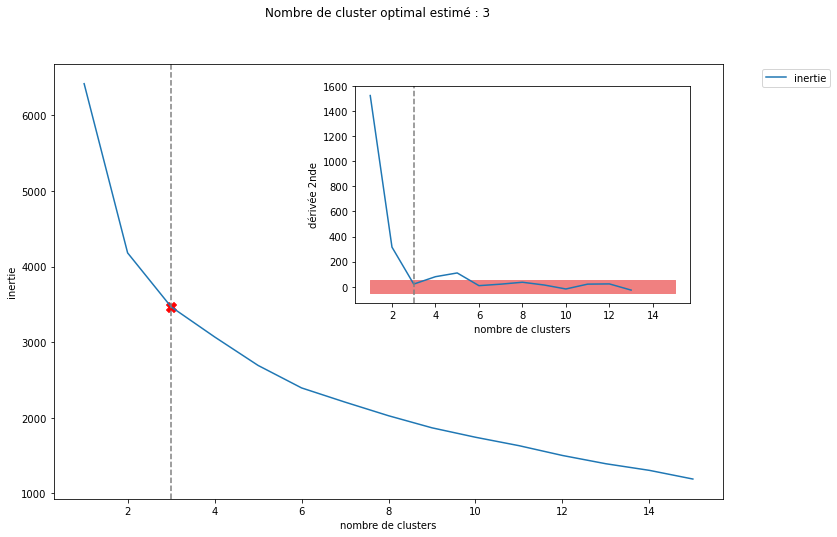

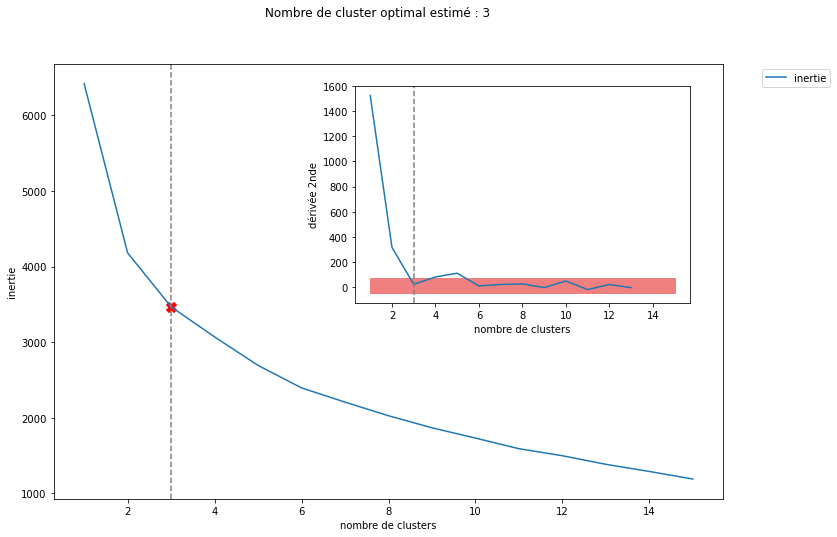

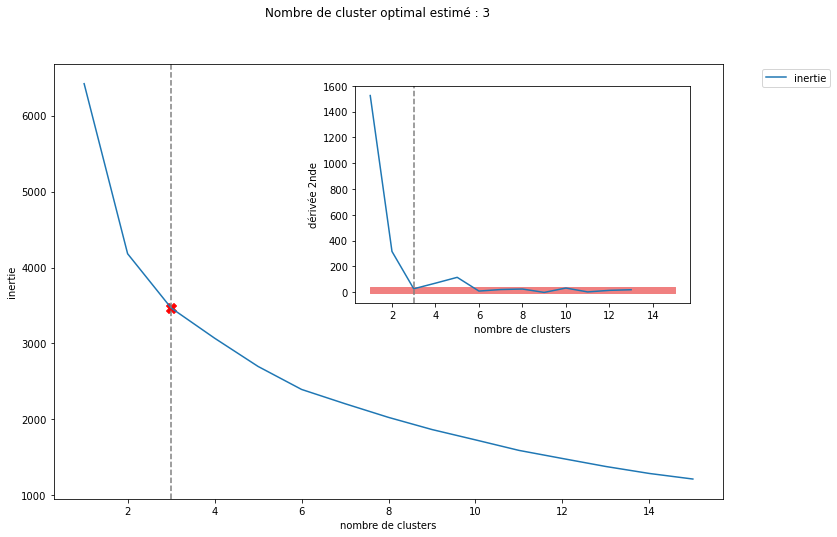

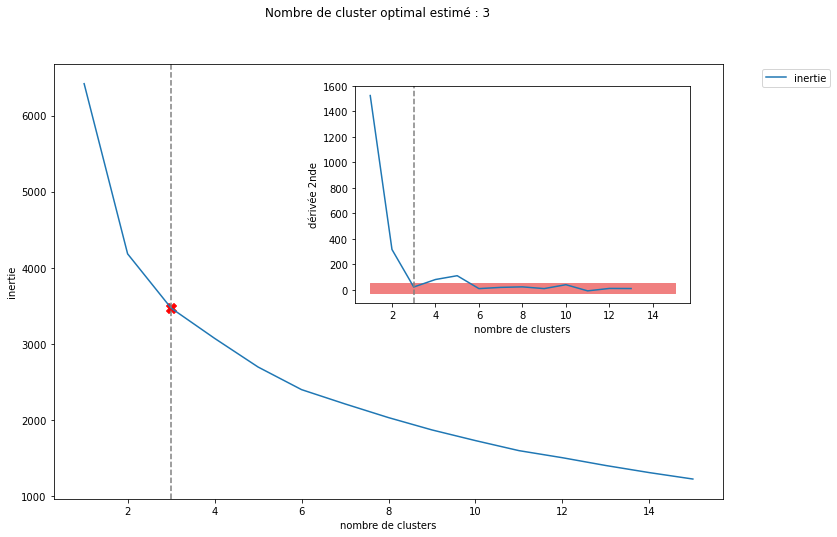

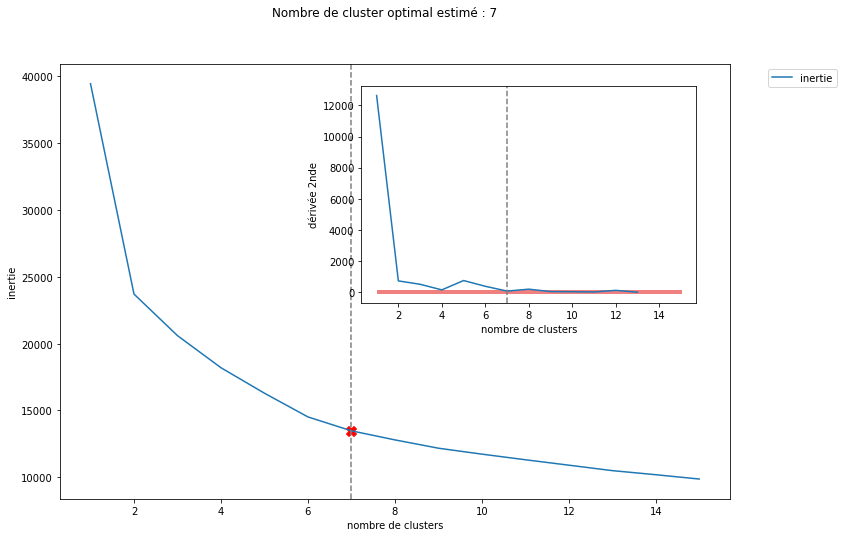

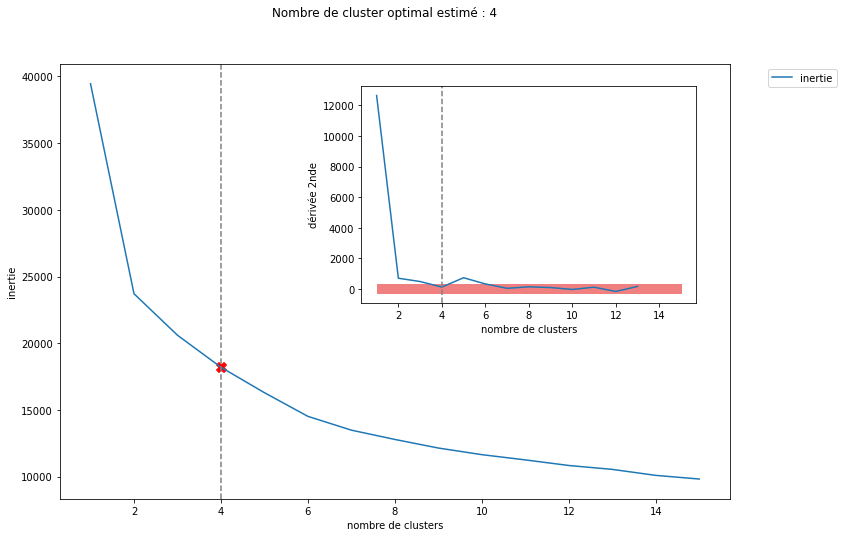

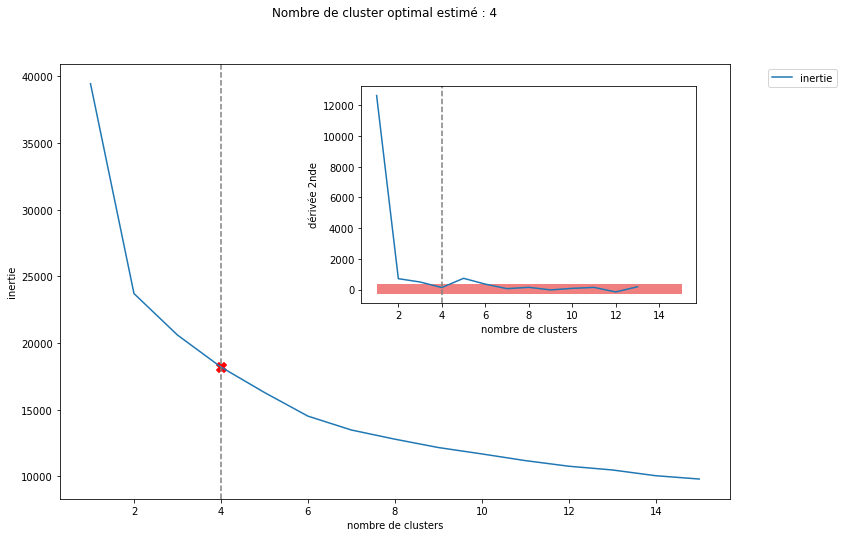

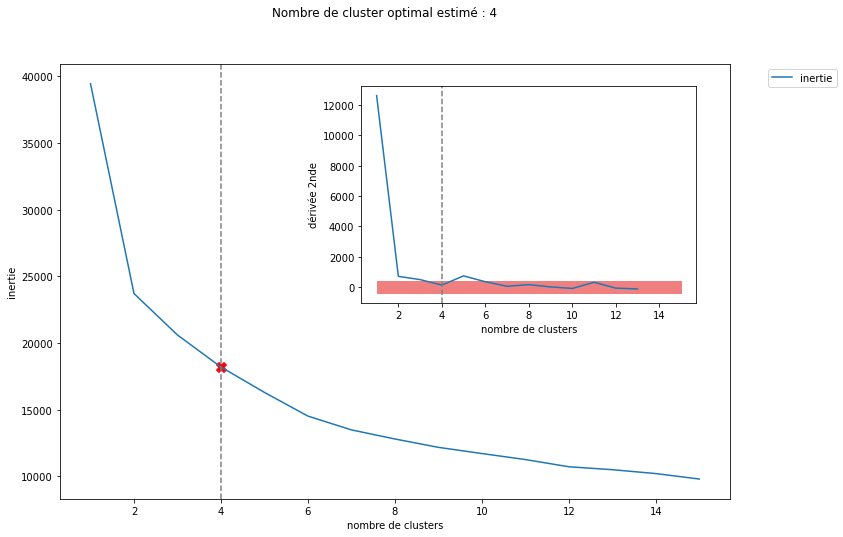

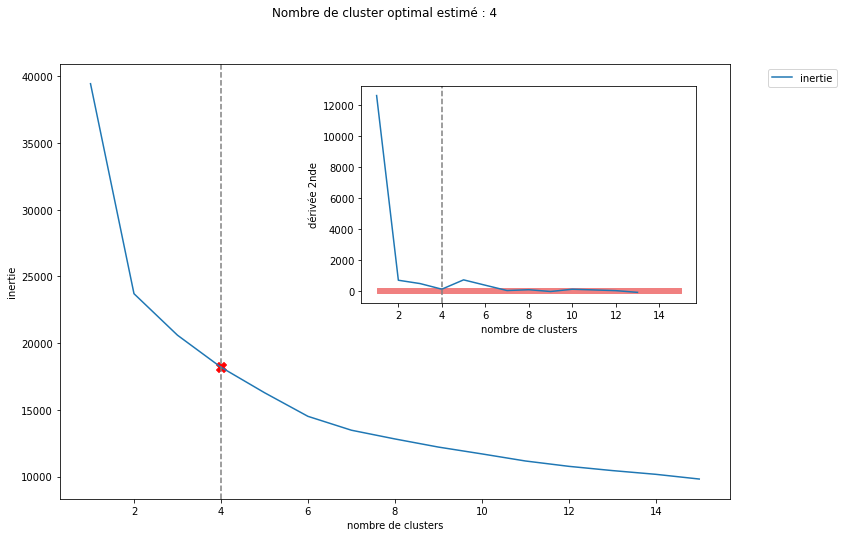

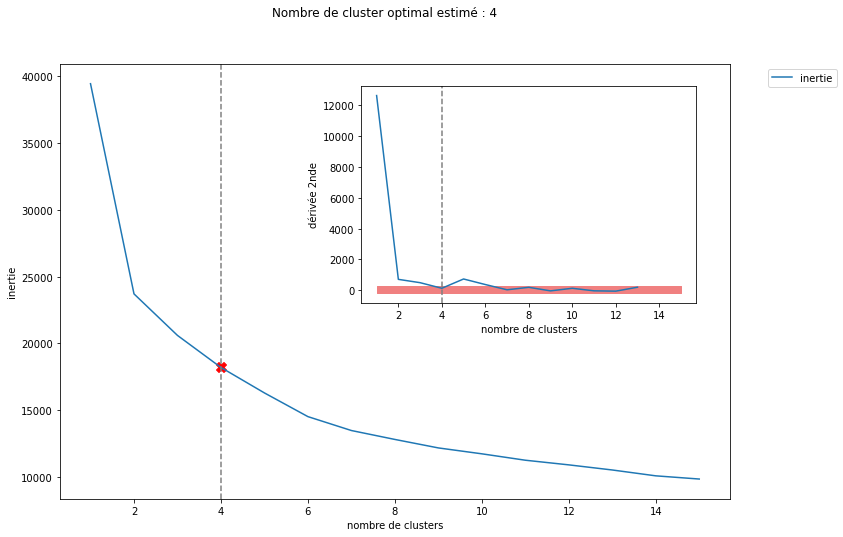

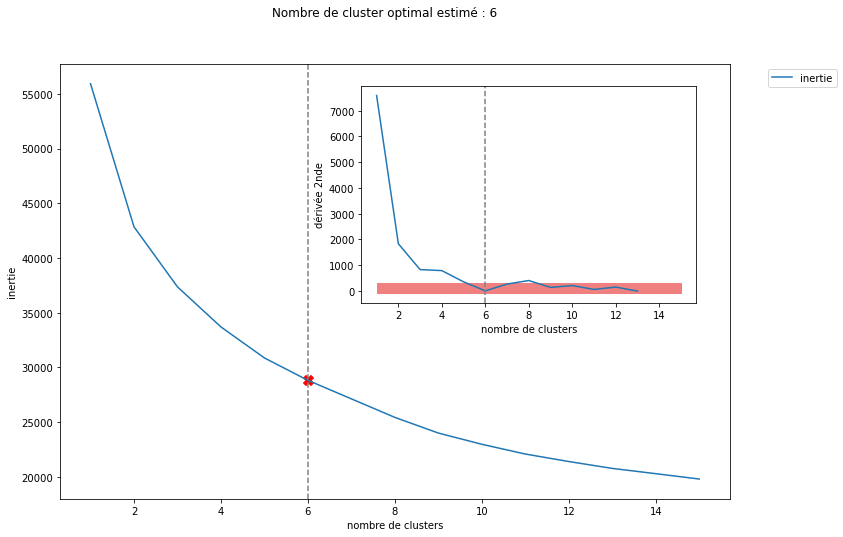

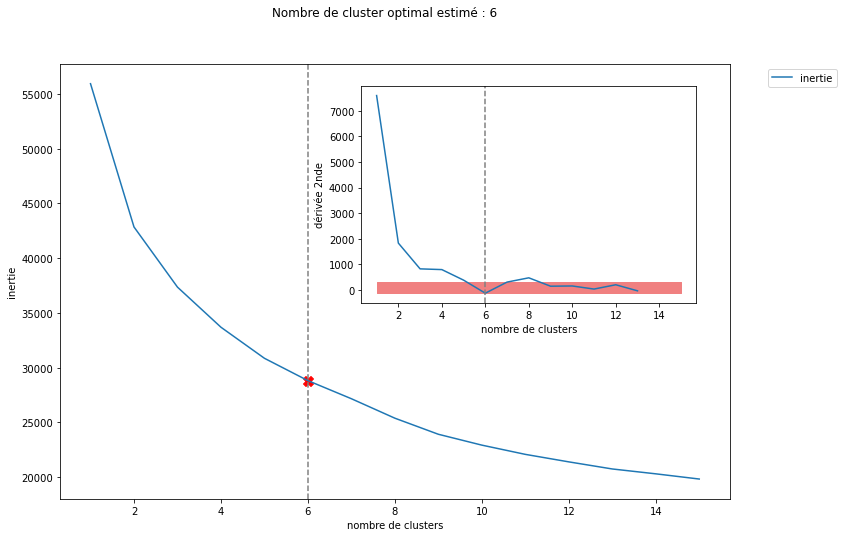

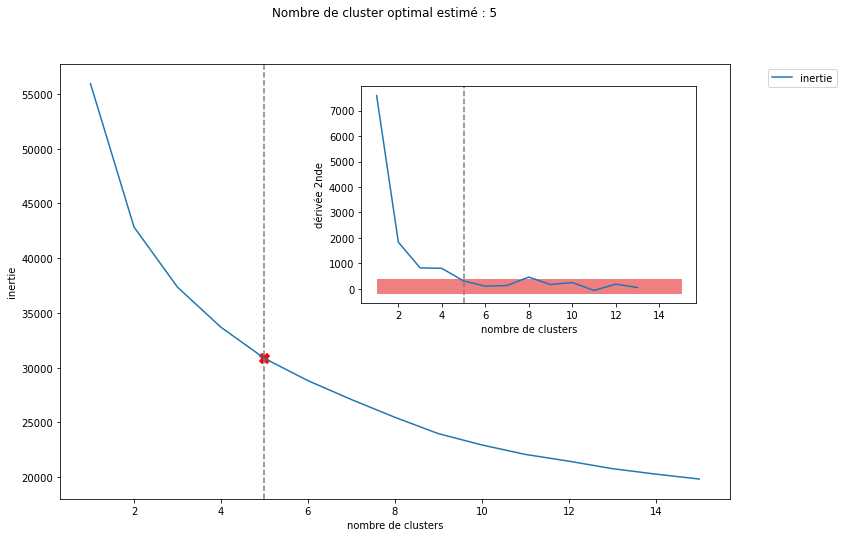

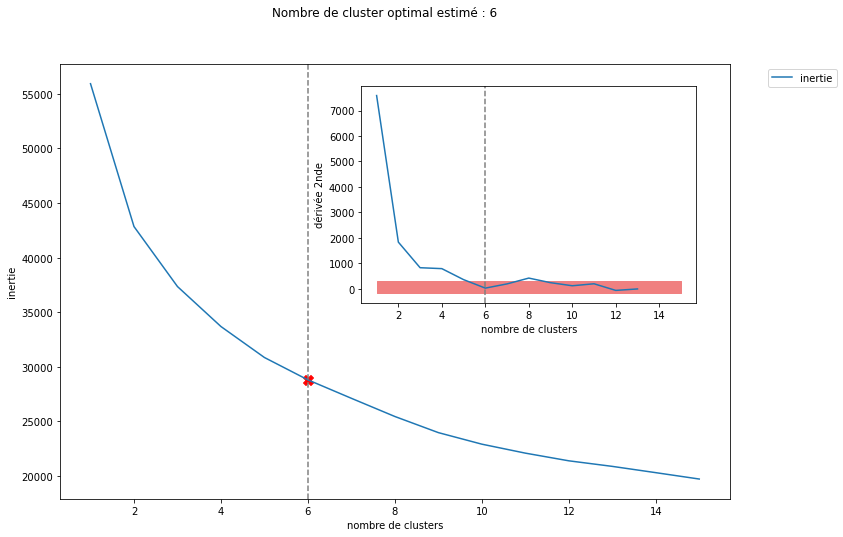

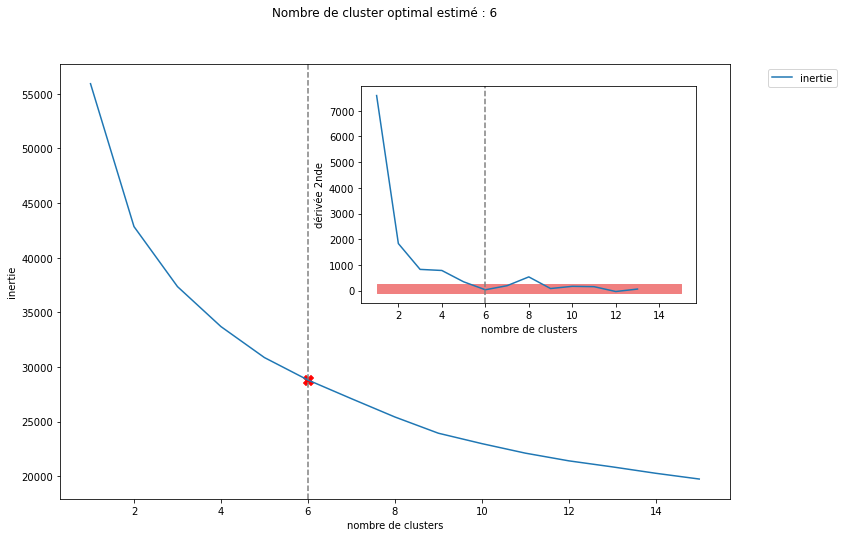

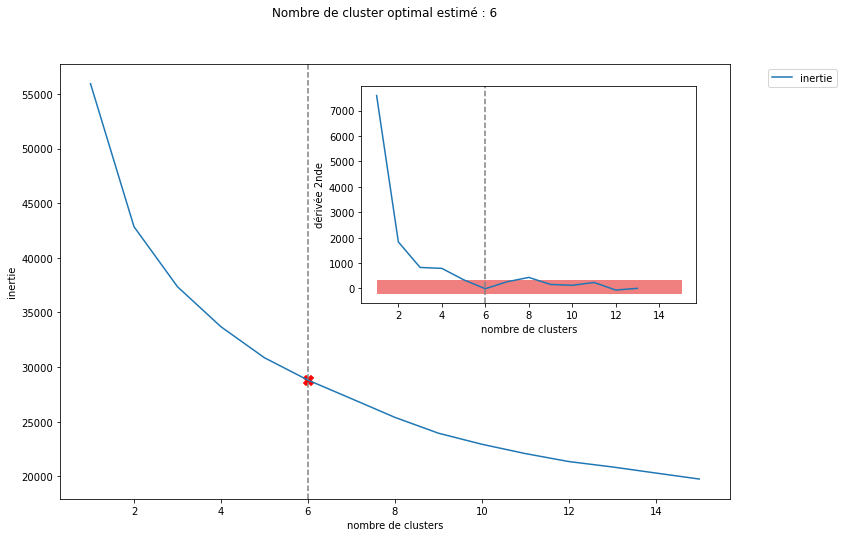

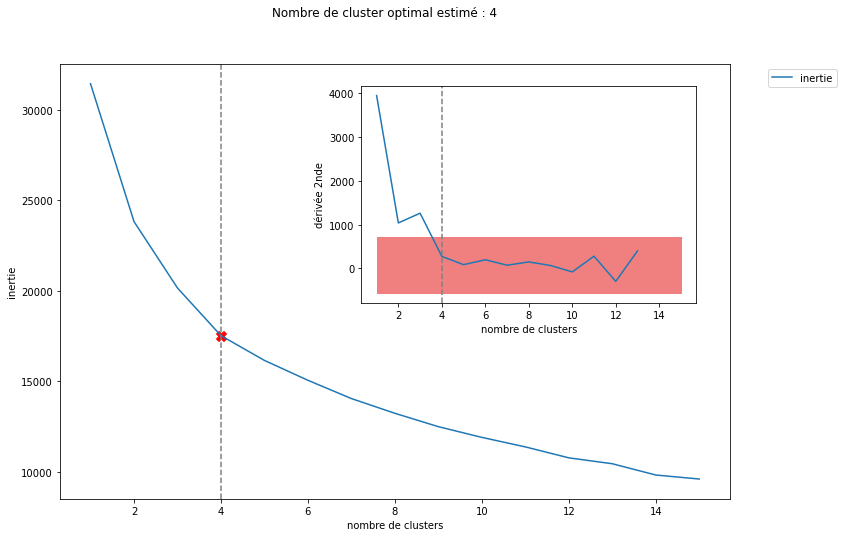

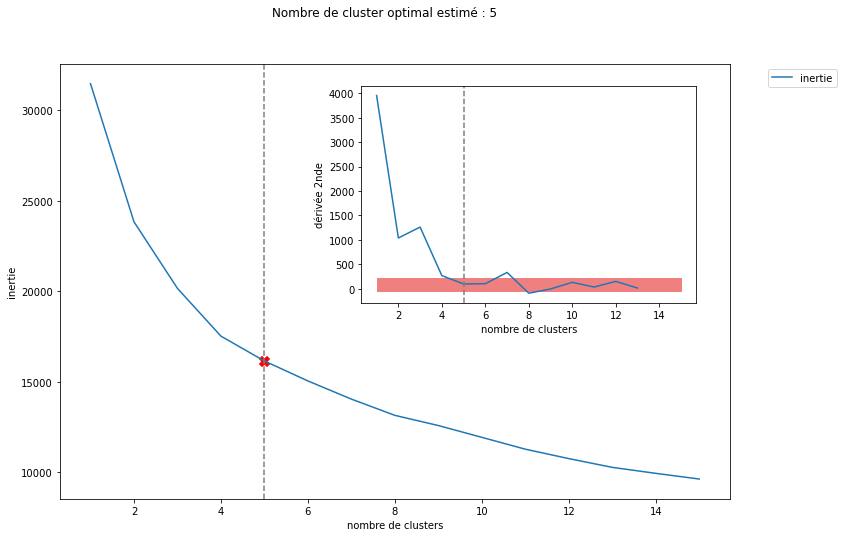

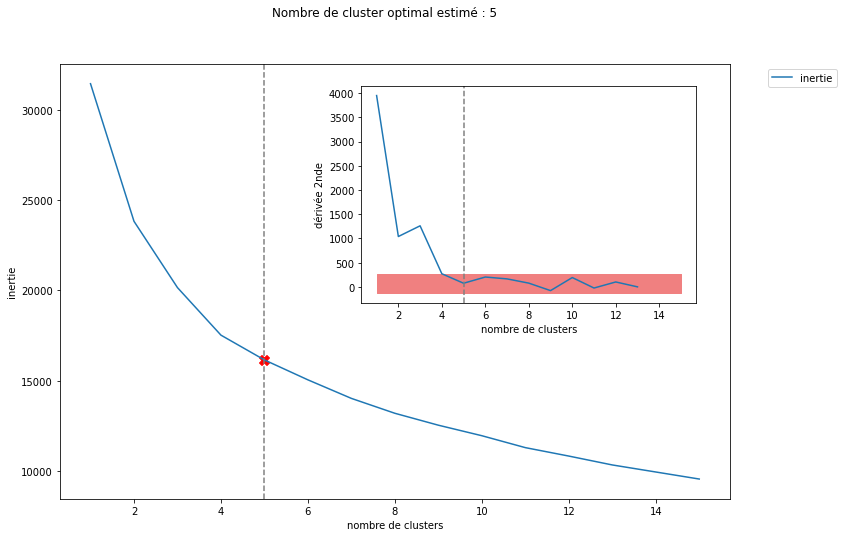

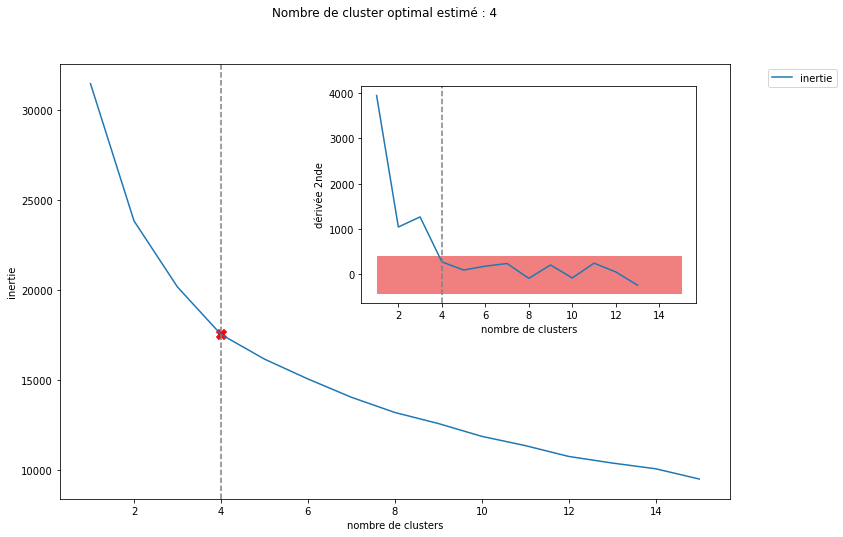

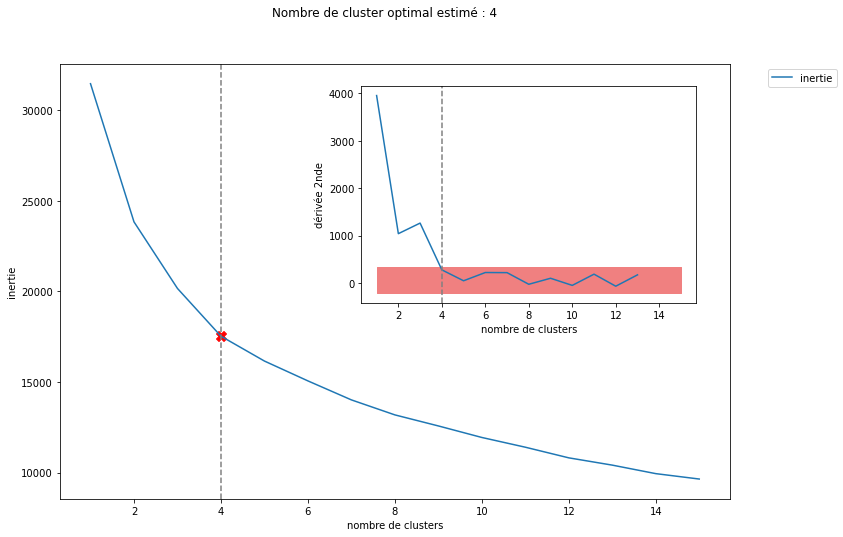

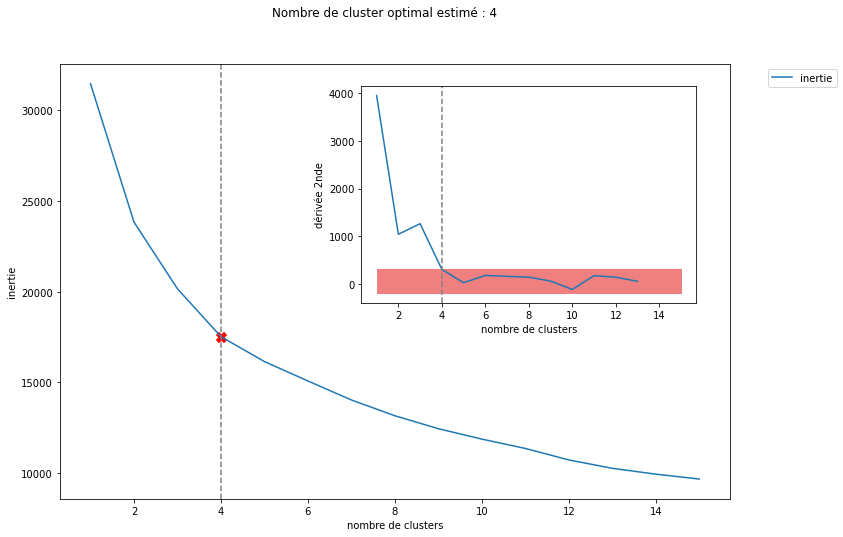

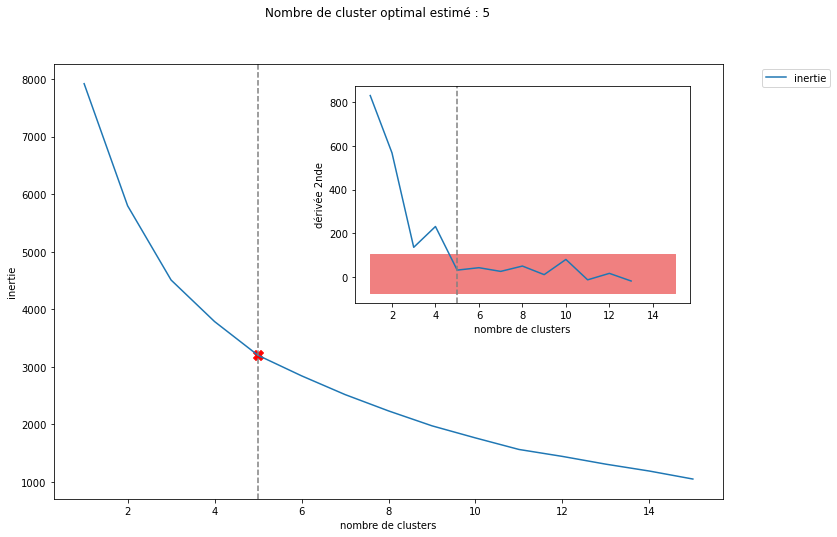

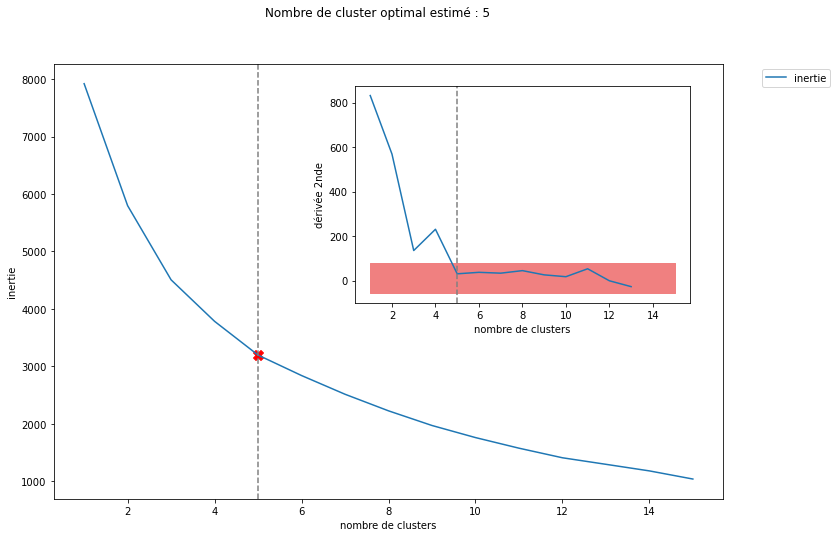

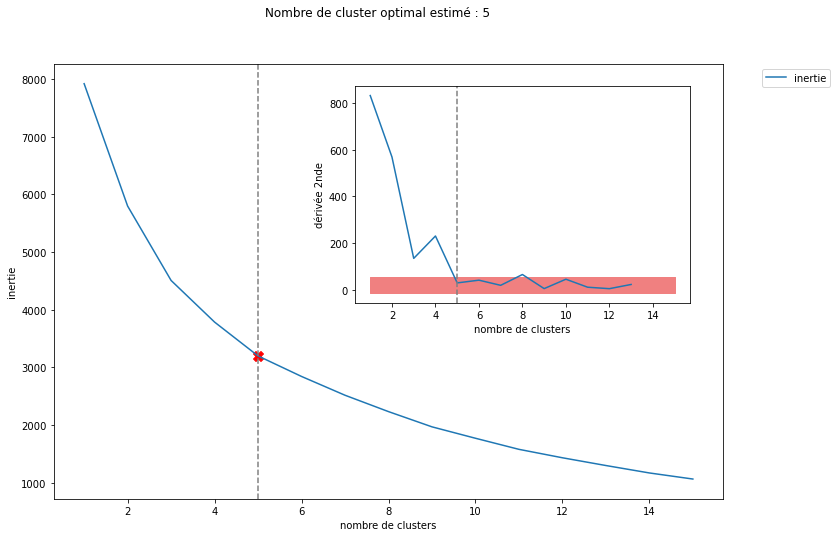

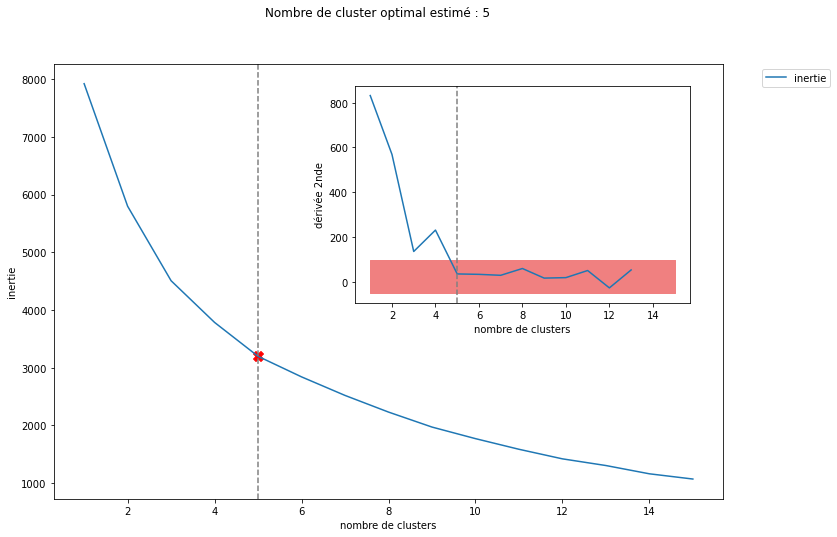

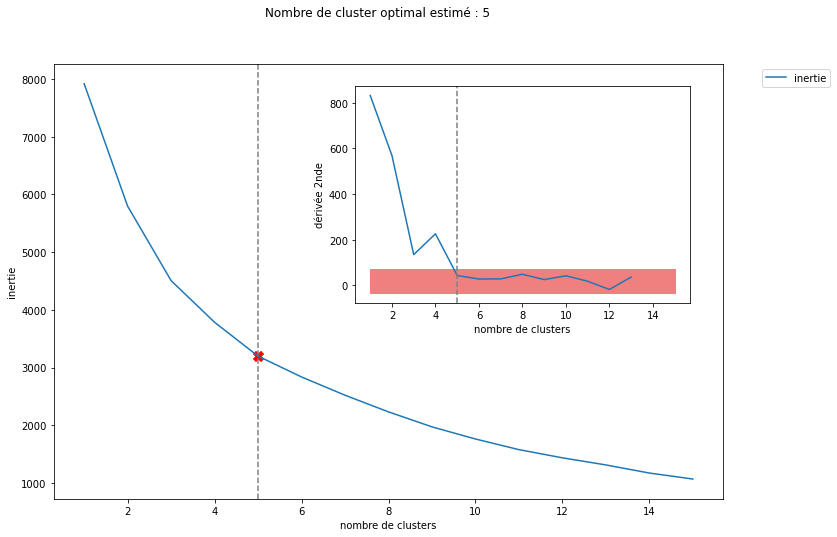

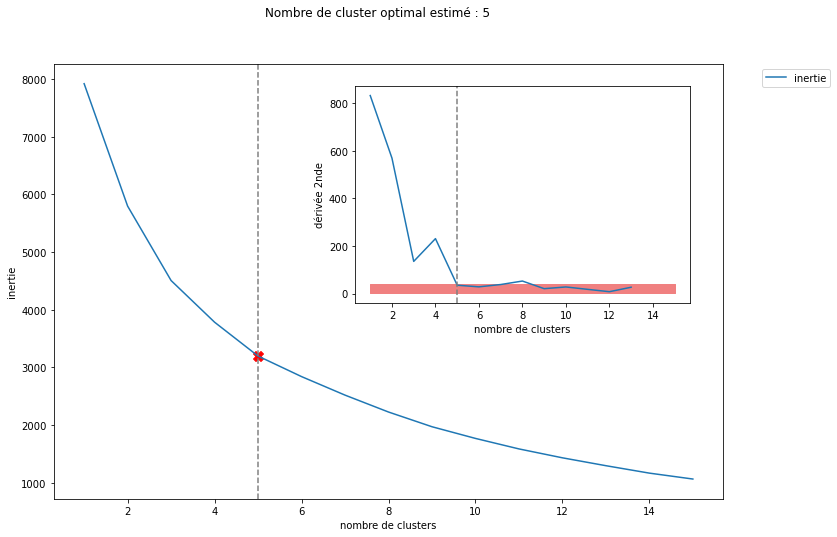

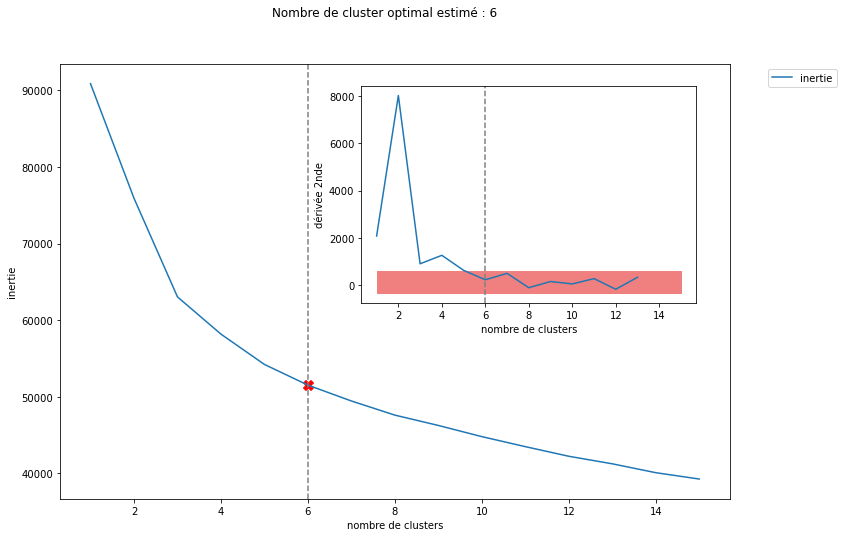

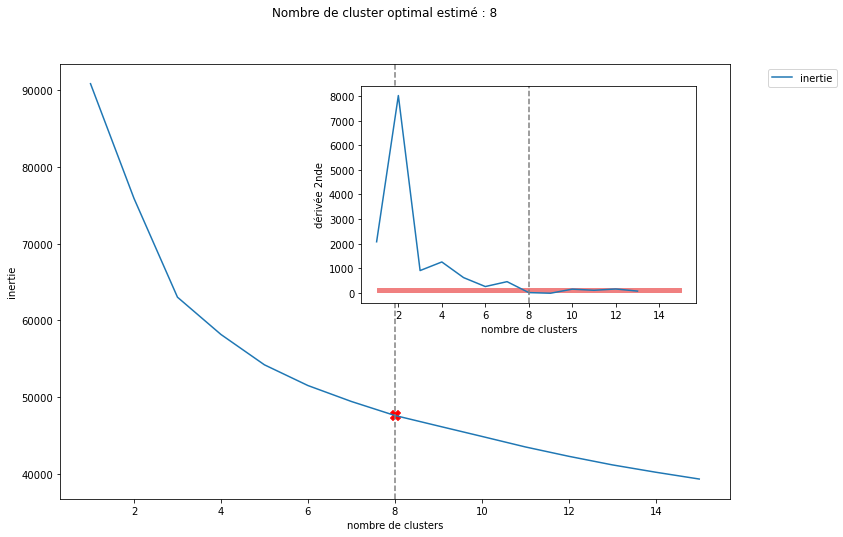

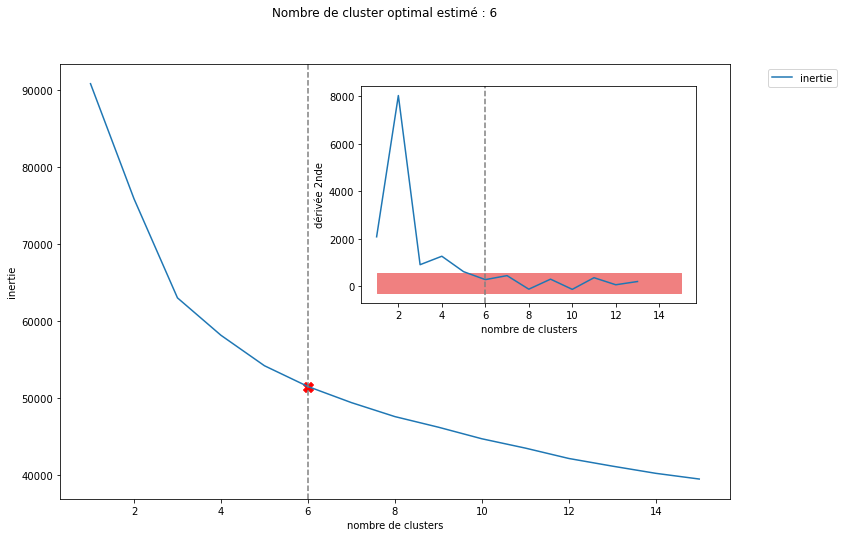

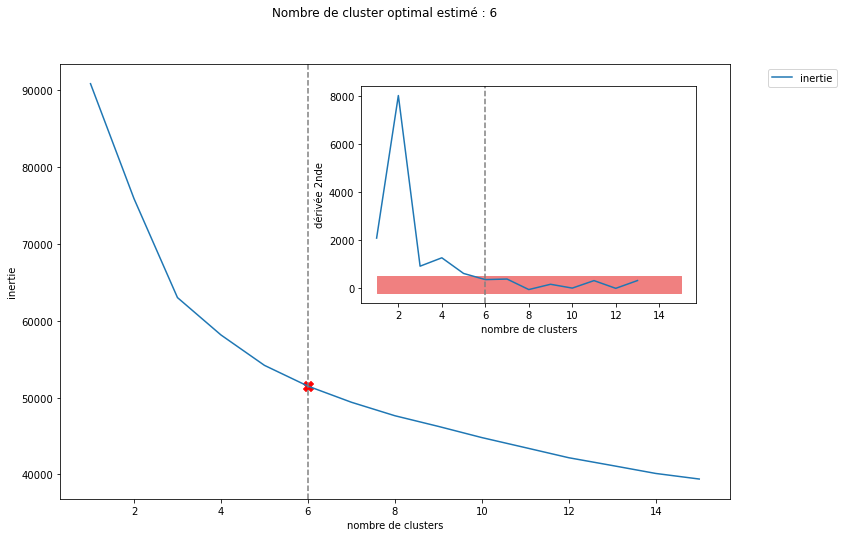

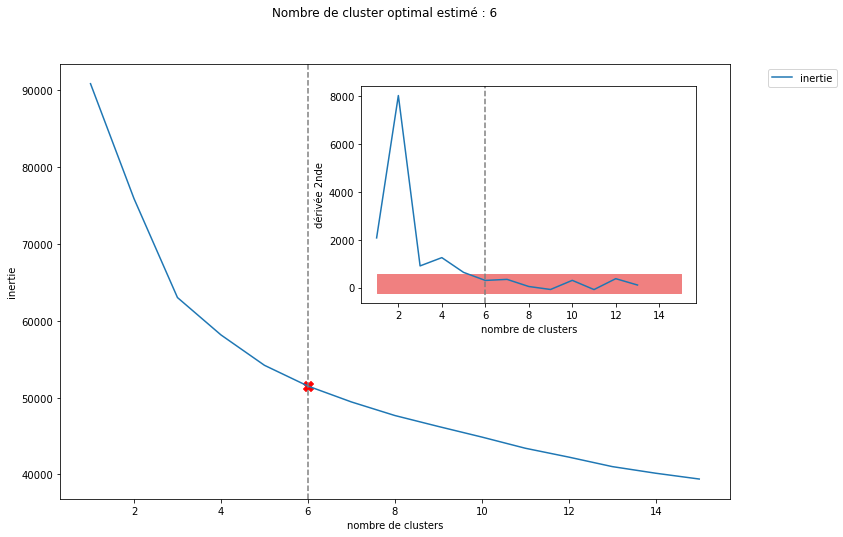

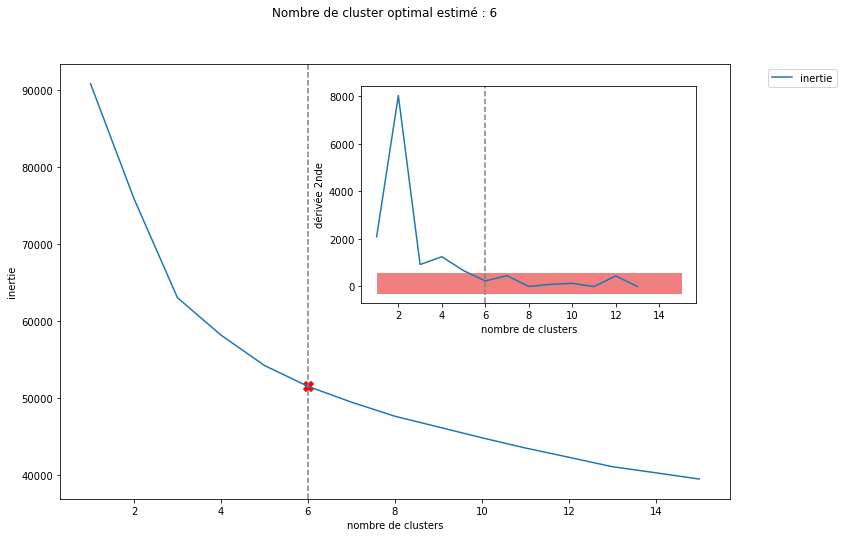

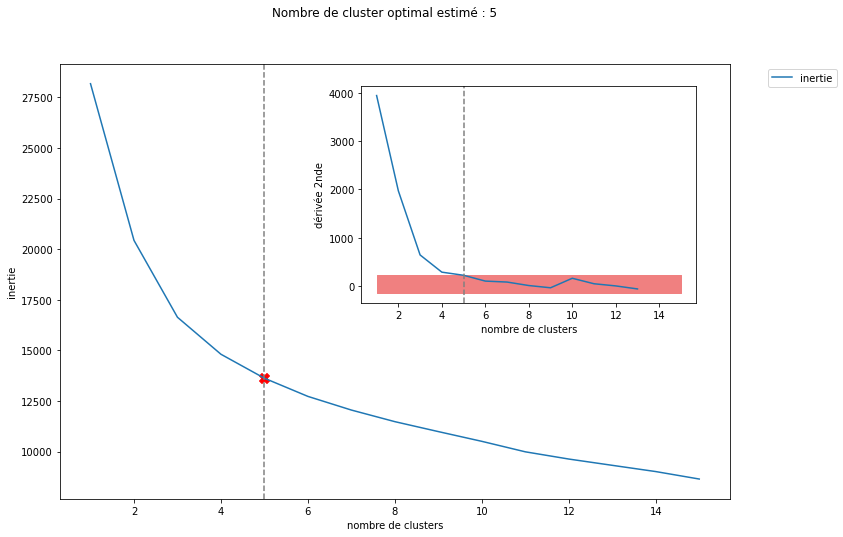

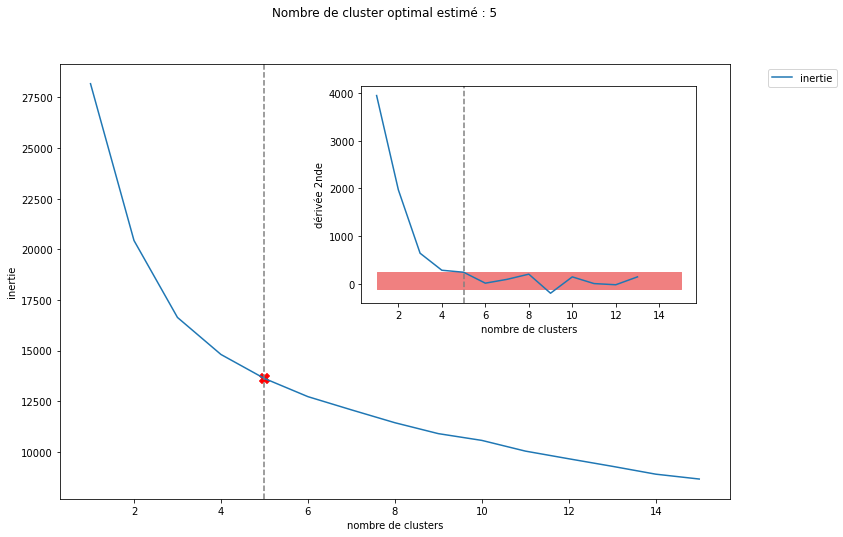

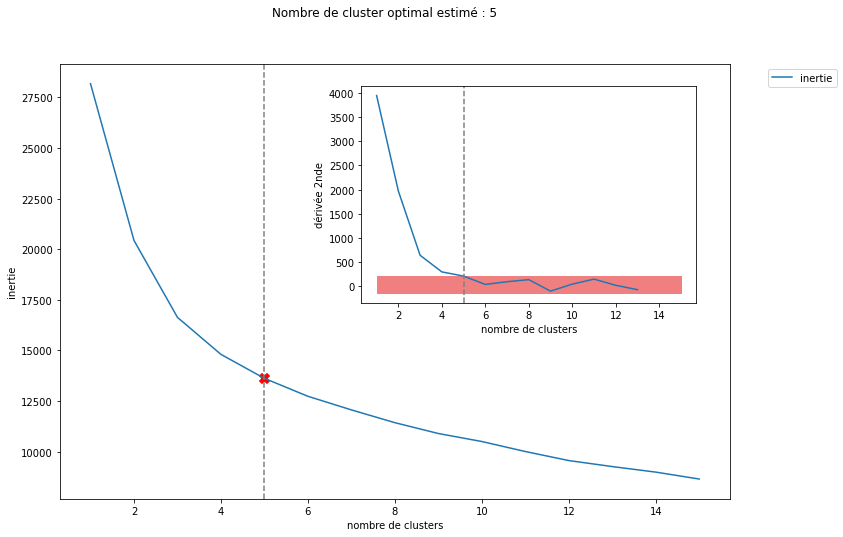

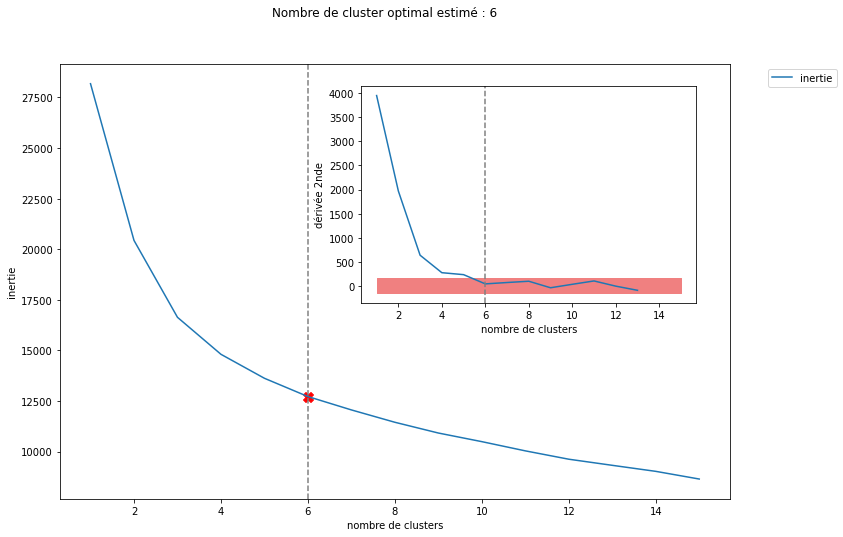

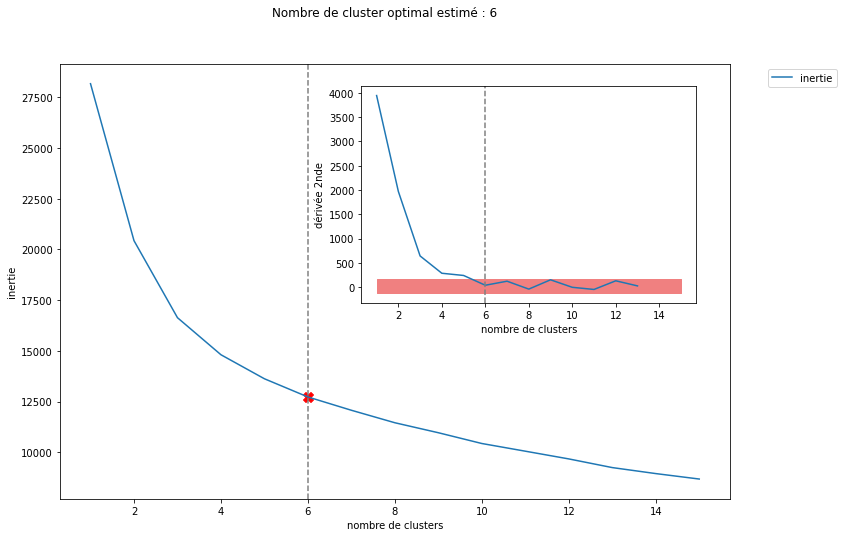

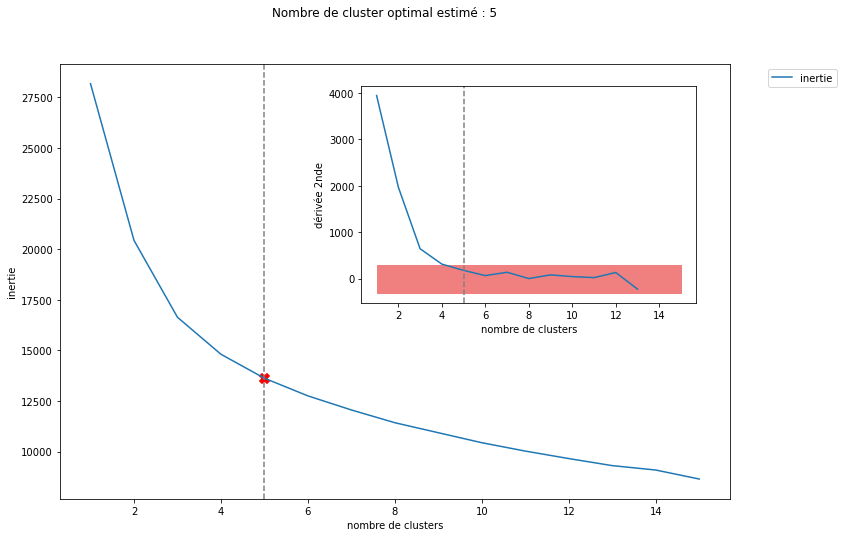

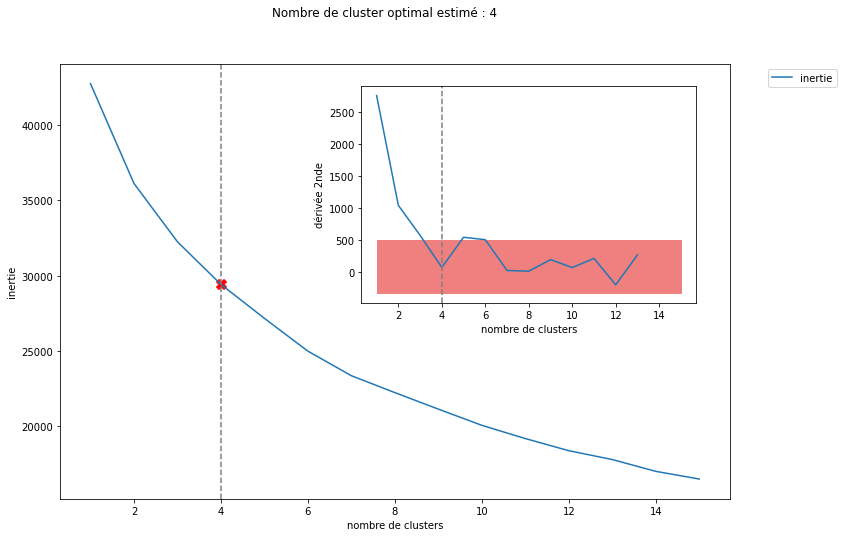

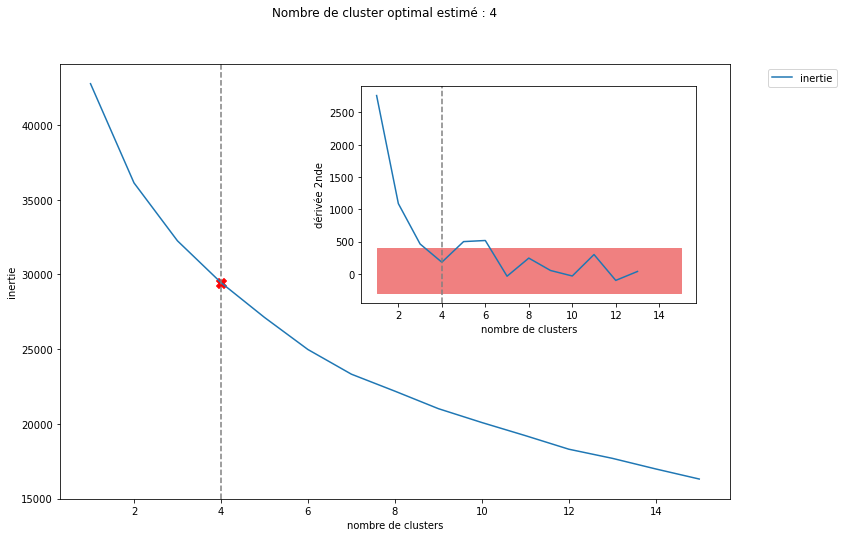

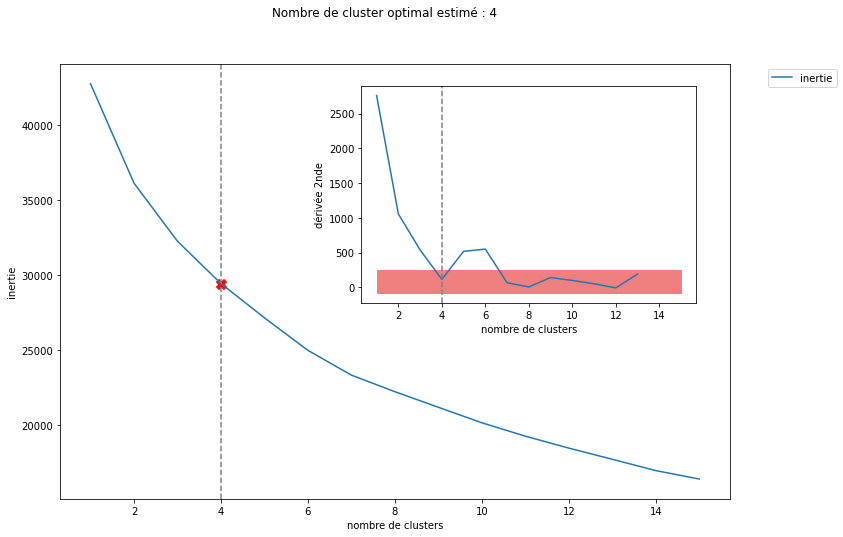

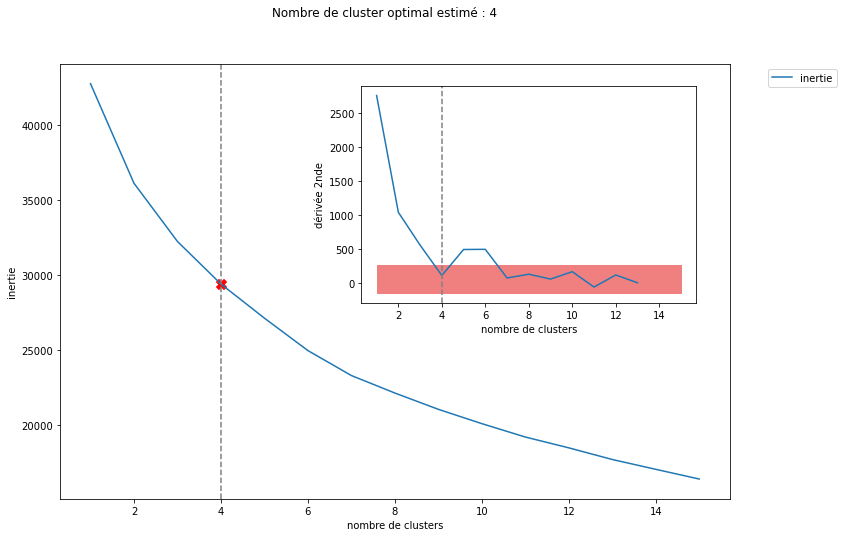

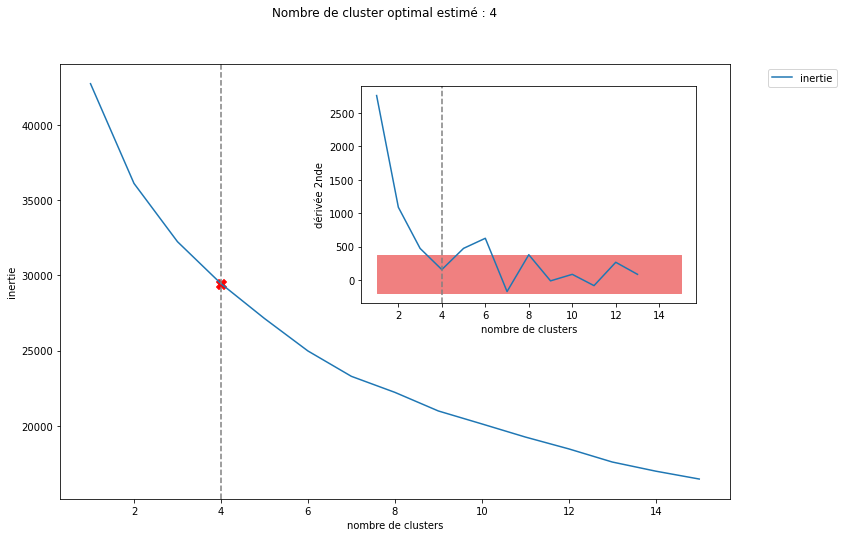

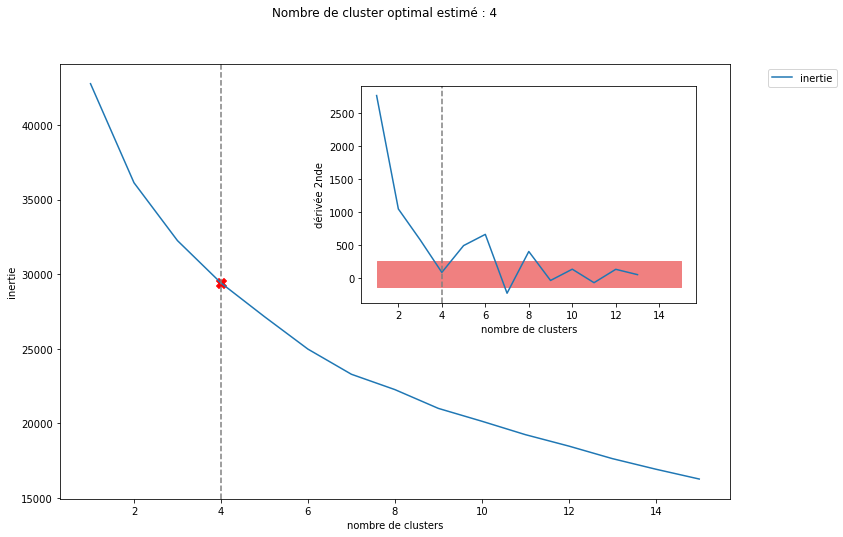

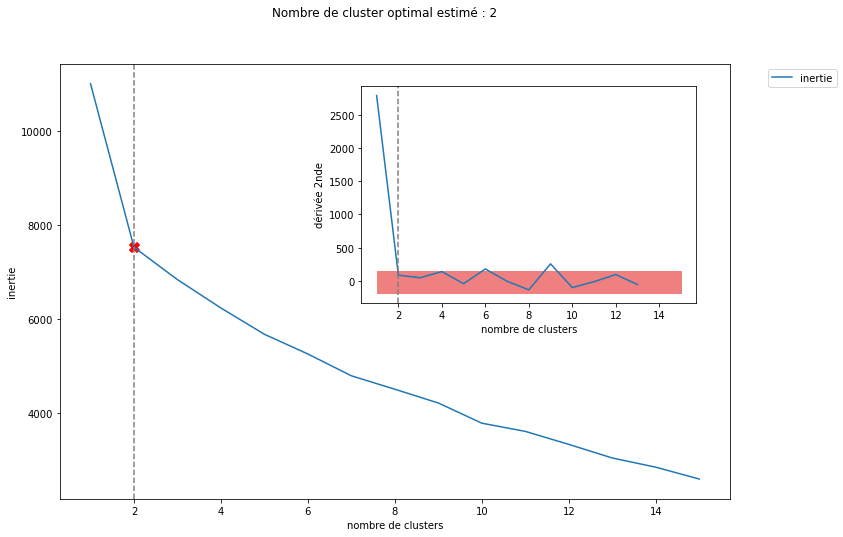

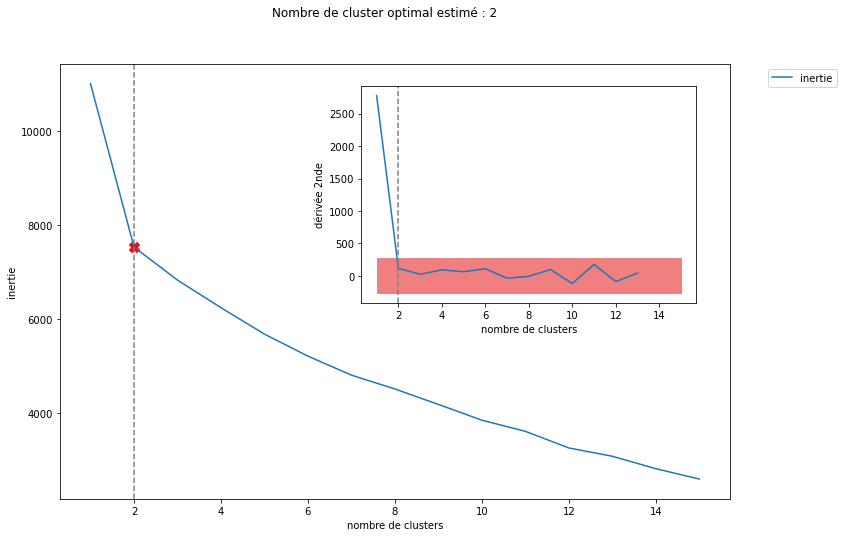

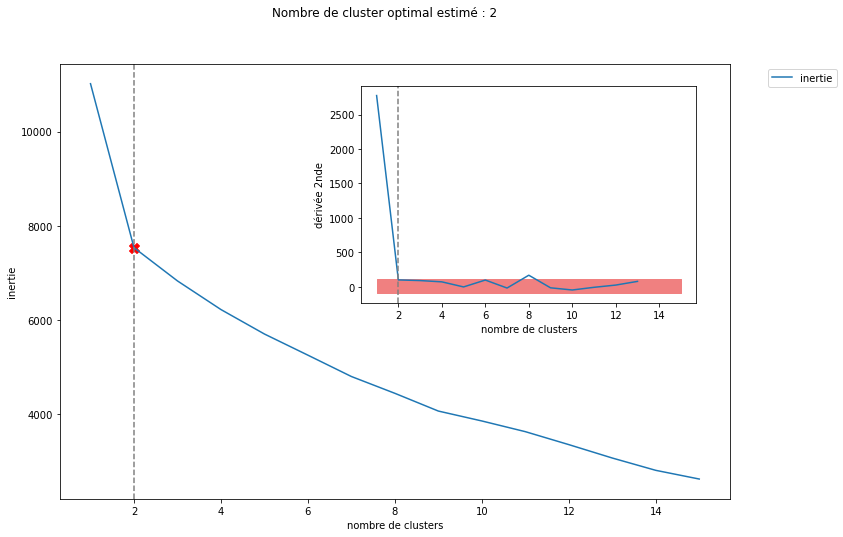

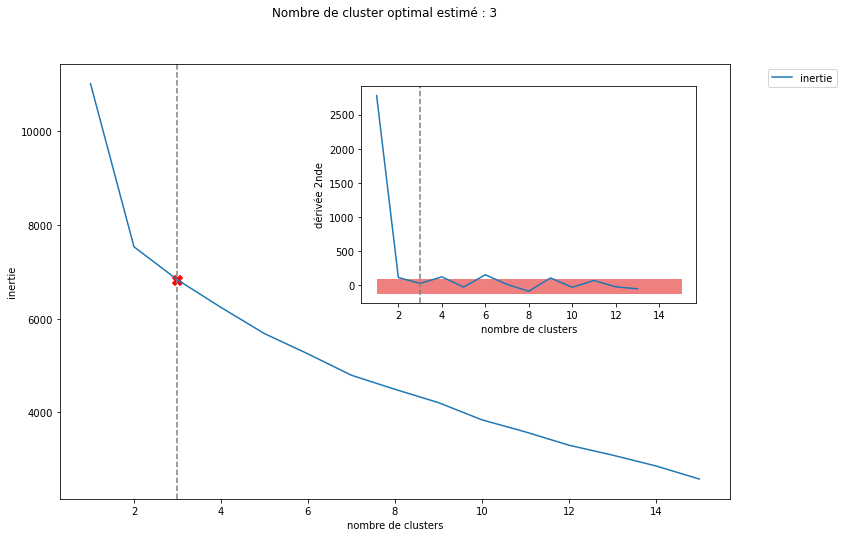

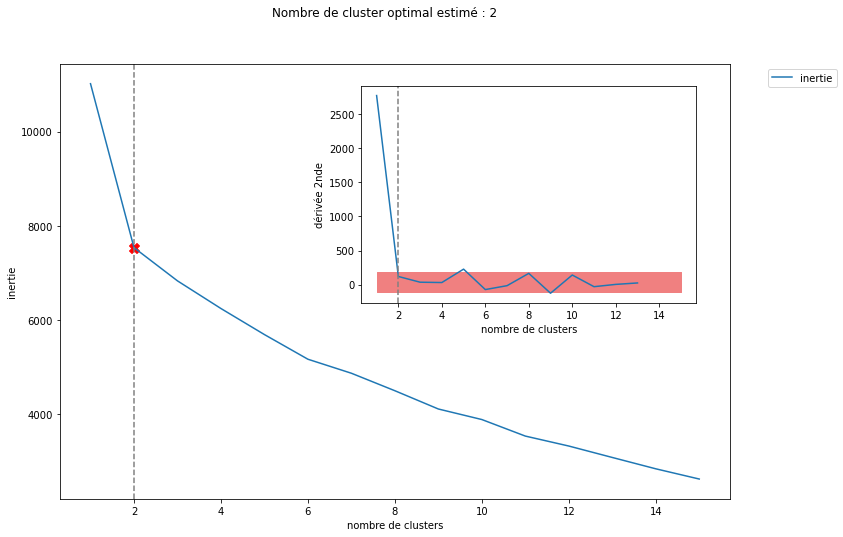

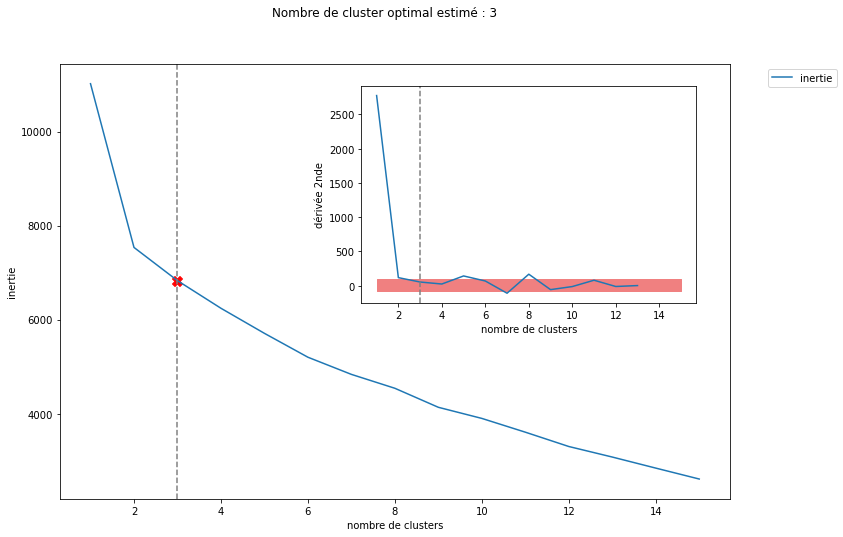

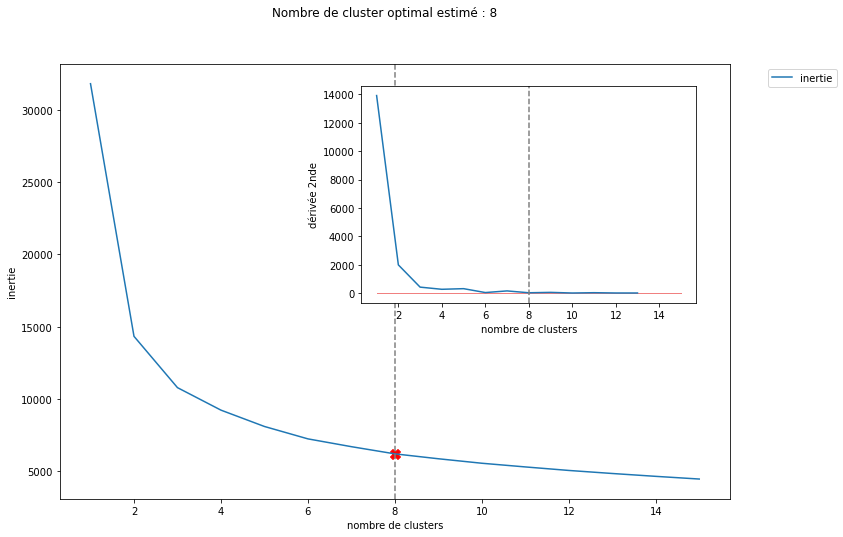

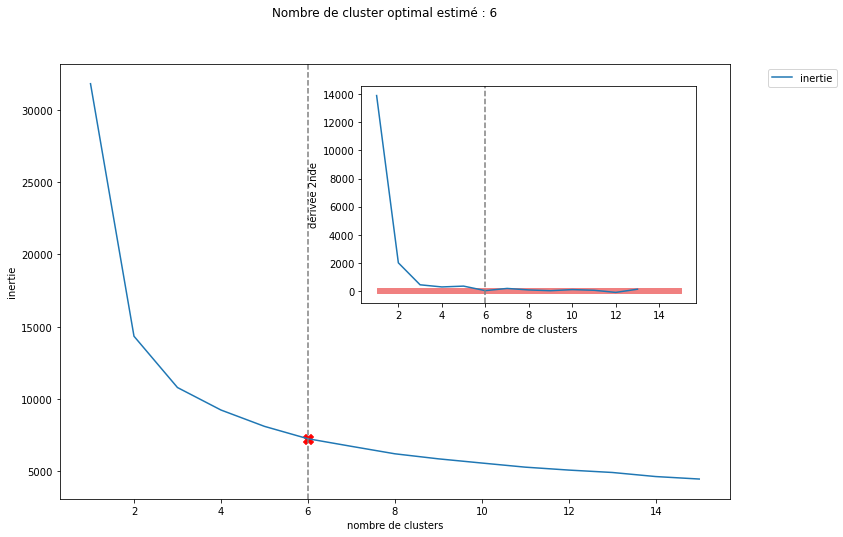

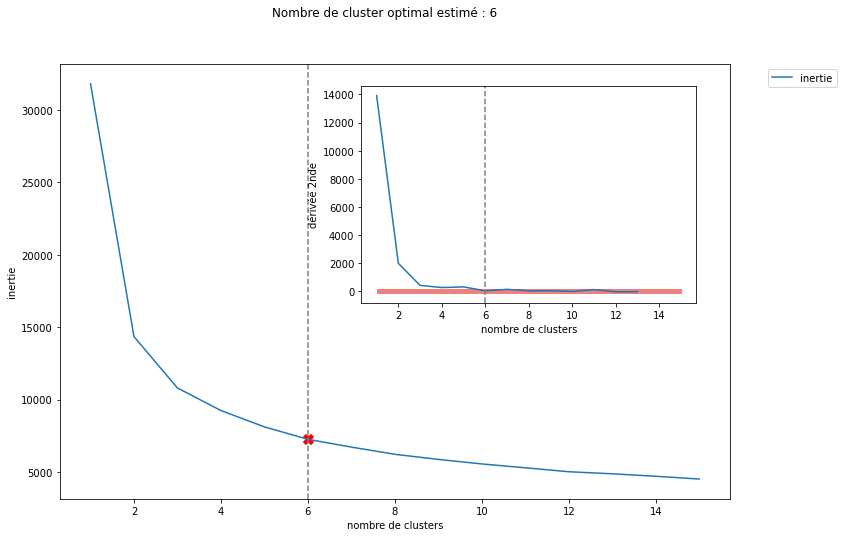

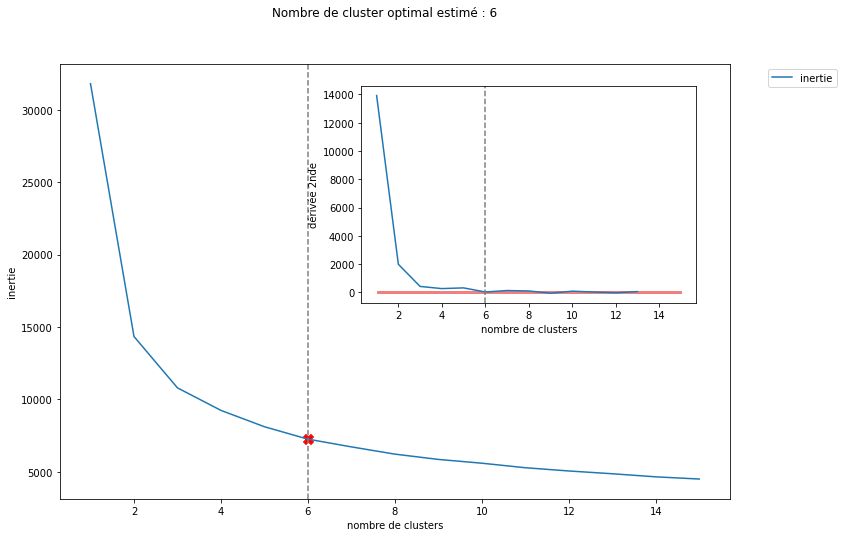

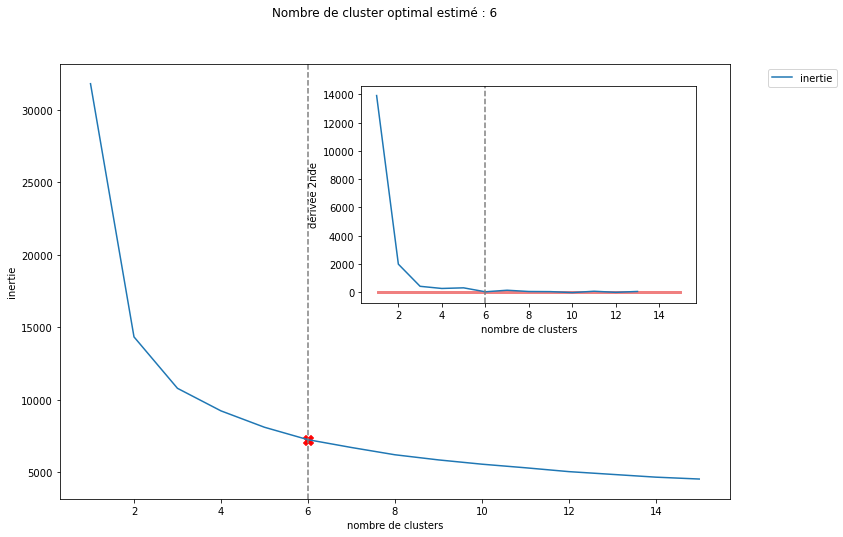

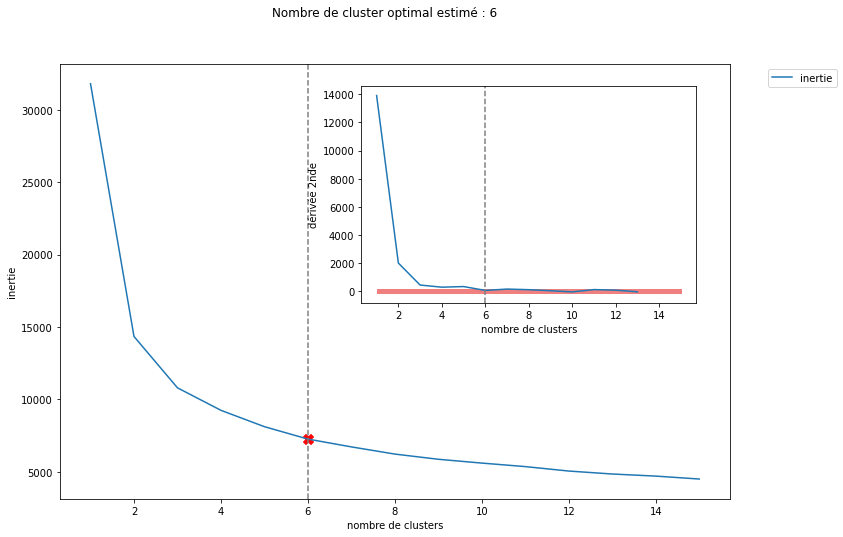

In [39]:
list_regions = ["ARA", 
               "BFC", 
               "BRE", 
               "CVL", 
               "GES", 
               "HDF", 
               "IDF", 
               "NAQ", 
               "NOR", 
               "OCC", 
               "PAC", 
               "PDL"]

list_regions = ["BRE", 
               "CVL", 
               "GES", 
               "HDF", 
               "IDF", 
               "NAQ", 
               "NOR", 
               "OCC", 
               "PAC", 
               "PDL"]

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
scaler = StandardScaler()

for region in list_regions :
    data = pd.read_csv(f"../data/clusters/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)
    data = scaleColumns(data)
    for iteration in range (1,7):
        print("région : ", region, " - iteration : ", iteration)
        df_resultats.loc[region, iteration], results = f_clusters_coude(data, n_init=400, plage=(1,16))

In [40]:
df_resultats.head(14)

1    2    3    4    5    6
ARA  3.0  3.0  3.0  3.0  3.0  5.0
BFC  5.0  5.0  5.0  5.0  5.0  5.0
BRE  3.0  3.0  3.0  3.0  3.0  3.0
CVL  7.0  4.0  4.0  4.0  4.0  4.0
GES  6.0  6.0  5.0  6.0  6.0  6.0
HDF  4.0  5.0  5.0  4.0  4.0  4.0
IDF  5.0  5.0  5.0  5.0  5.0  5.0
NAQ  6.0  8.0  6.0  6.0  6.0  6.0
NOR  5.0  5.0  5.0  6.0  6.0  5.0
OCC  4.0  4.0  4.0  4.0  4.0  4.0
PAC  2.0  2.0  2.0  3.0  2.0  3.0
PDL  8.0  6.0  6.0  6.0  6.0  6.0

# Chargement des données

In [3]:
region = "CVL"

In [4]:
# Import du csv et conversion en dataframe
custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")
data = pd.read_csv(f"../data/clusters/{region}.csv", sep = ";", parse_dates=True, index_col="date_mesure", date_parser=custom_date_parser)

print(f"Il y a {data.shape[1]} piezos pour le clustering dans le dataframe.")

Il y a 117 piezos pour le clustering dans le dataframe.


## Normalisation StandardScaler

In [5]:
scaler = StandardScaler()
data = scaleColumns(data)

In [6]:
data.head()

03646X0086_F1  03627X0052_P1  05475X0057_P1  04915X0009_F1AEP1  \
date_mesure                                                                   
2001-12-16        1.668336       2.096455      -0.121471           0.554723   
2001-12-23        1.675449       2.100810      -0.449402           0.456357   
2001-12-30        1.722604       2.114602      -0.539805           0.881066   
2002-01-06        1.689496       2.074678       0.279138           1.089370   
2002-01-13        1.759731       2.087986      -0.183512           0.878751   

             05421X0001_FAEP1  05943X0006_FAEP1  03282X0043_S1  02896X0013_F2  \
date_mesure                                                                     
2001-12-16           1.935443         -0.115598       2.092888       0.356649   
2001-12-23           1.942940         -0.094709       2.096915       0.337681   
2001-12-30           1.999701          0.103736       2.115037       0.497555   
2002-01-06           1.914024          0.239515       2.073760       0.652009   
2002-01-13           2.021656          0.051514       2.084834       0.620306   

             03646X0087_F2  04277X0062_FAEP2  ...  05914X0007_PAEP  \
date_mesure                                   ...                    
2001-12-16        1.434881         -1.751882  ...         1.074371   
2001-12-23        1.477883         -2.446056  ...         1.015706   
2001-12-30        1.616296         -1.576131  ...         0.963244   
2002-01-06        1.631078         -1.157209  ...         0.909623   
2002-01-13        1.631078         -1.500343  ...         0.861557   

             03252X0011_S  03248X0015_S  05446X0136_S  05465X0001_PZ  \
date_mesure                                                            
2001-12-16       0.808649      1.550421     -0.704929      -0.314972   
2001-12-23       0.726595      1.492713     -0.704353      -0.331127   
2001-12-30       0.808649      1.573052     -0.640324      -0.284878   
2002-01-06       1.208666      1.579518      0.491429       0.262613   
2002-01-13       1.103534      1.507989      0.533264       0.320160   

             04597X0065_PZ  03272X0006_PZ  04894X0016_PZ  03622X0027_PZ  \
date_mesure                                                               
2001-12-16        0.912666       1.286793       1.625406       2.257757   
2001-12-23        0.873725       1.311921       1.615781       2.250922   
2001-12-30        0.951606       1.339066       1.633106       2.249555   
2002-01-06        1.067094       1.319234       1.601344       2.201938   
2002-01-13        1.124503       1.340772       1.550812       2.182572   

             04866X0038_PZ  
date_mesure                 
2001-12-16       -0.308020  
2001-12-23       -0.385935  
2001-12-30       -0.380741  
2002-01-06        0.015514  
2002-01-13        0.169861  

[5 rows x 117 columns]

<AxesSubplot:xlabel='date_mesure'>

<Figure size 1080x864 with 0 Axes>

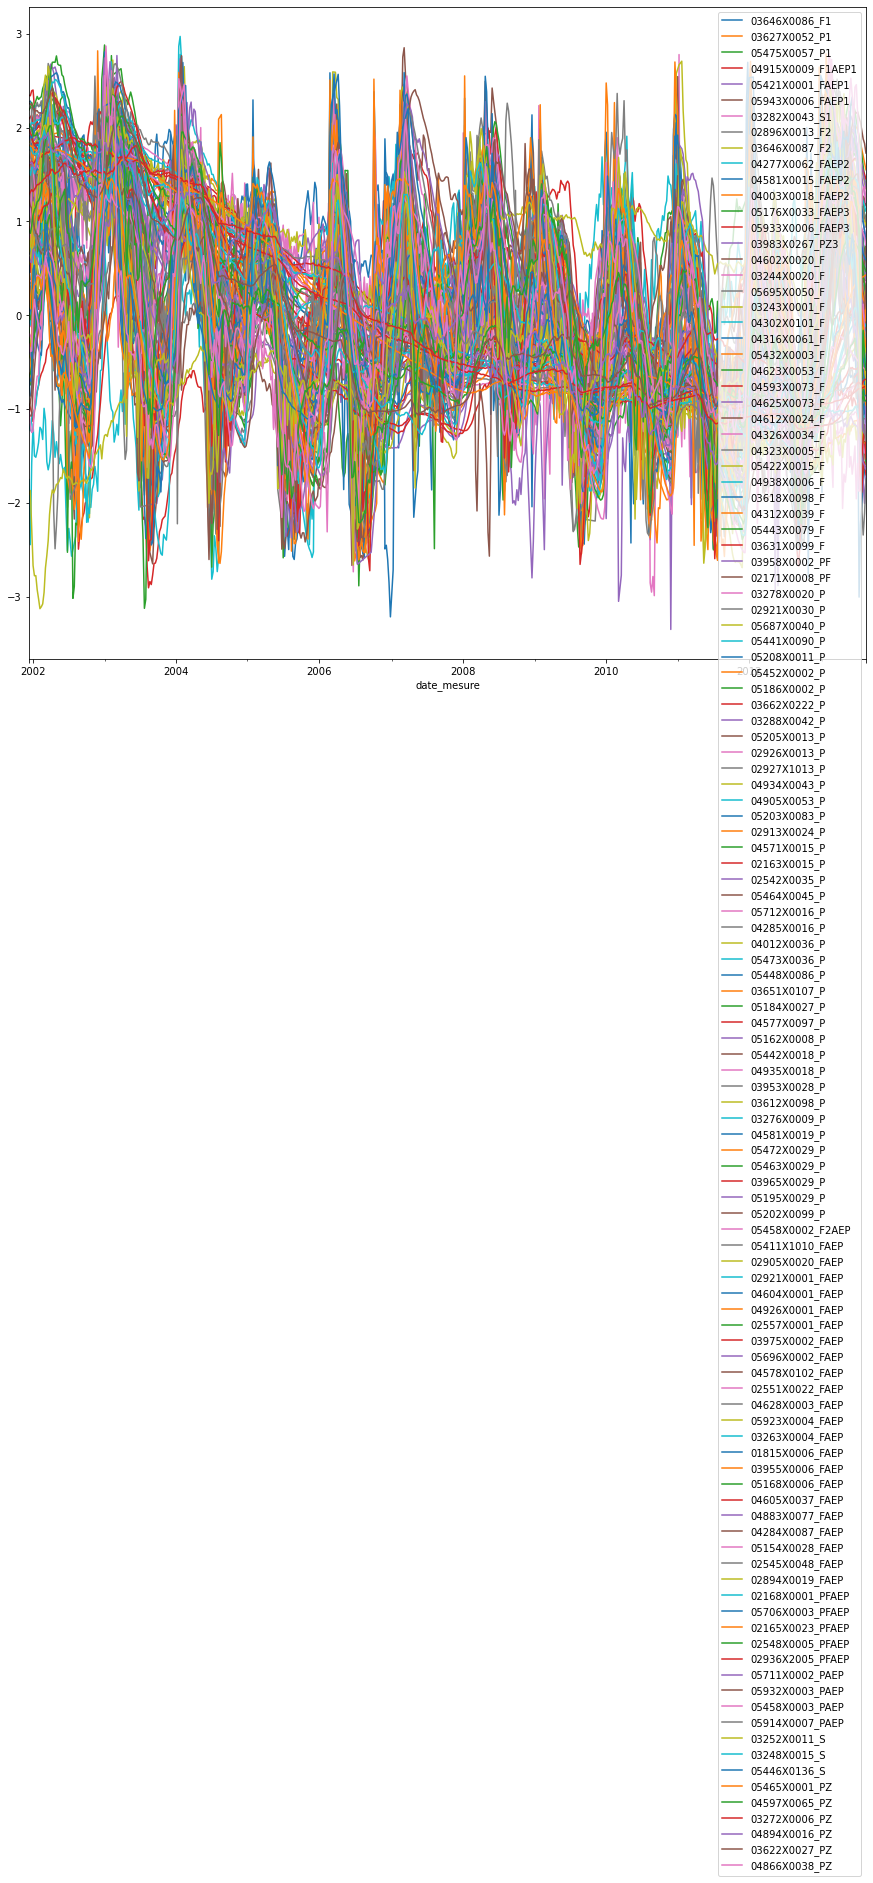

In [9]:
data.plot(figsize = (15,12))

## Analyse du nombre optimal de clusters

Calcul de l'inertie: 100%|██████████████████████████████████████████| 15/15 [00:30<00:00,  2.02s/it]


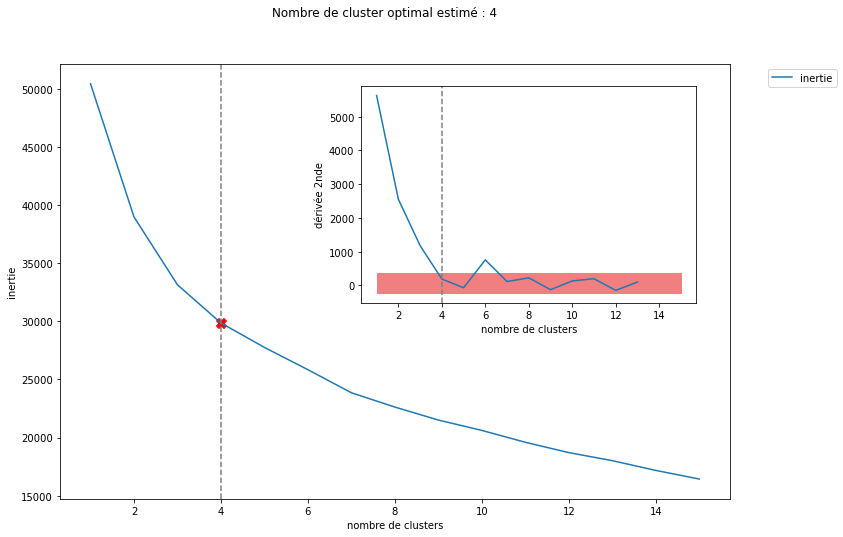

In [10]:
best_k, results = f_clusters_coude(data, n_init=400, plage=(1,16))

In [9]:
results.head(14)

inertia         deriv      deriv_2
1   50432.148572 -11460.689001  5625.932228
2   38971.459571  -5834.756772  2542.017609
3   33136.702799  -3292.739163  1130.867209
4   29843.963636  -2161.871954   217.730060
5   27682.091682  -1944.141894    90.057377
6   25737.949787  -1854.084518   514.317690
7   23883.865270  -1339.766828   292.742678
8   22544.098442  -1047.024150    24.541989
9   21497.074291  -1022.482161   162.786958
10  20474.592130   -859.695203   -18.661640
11  19614.896927   -878.356843    17.316793
12  18736.540084   -861.040050   172.006766
13  17875.500034   -689.033283          NaN
14  17186.466751           NaN          NaN

## Création des clusters

In [28]:
# Choix du nombre de clusters à créer
nbre_clusters = 3

<AxesSubplot:xlabel='cluster', ylabel='count'>

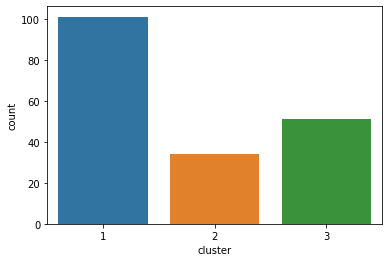

In [29]:
# Entrainement
cluster_table, cluster_centers = f_clusters_fit(data, nbre_clusters, n_init = 2000, max_iter = 500)

# répartition des piezos dans les clusters
sns.countplot(data = cluster_table, x = "cluster")

## Affichage des clusters

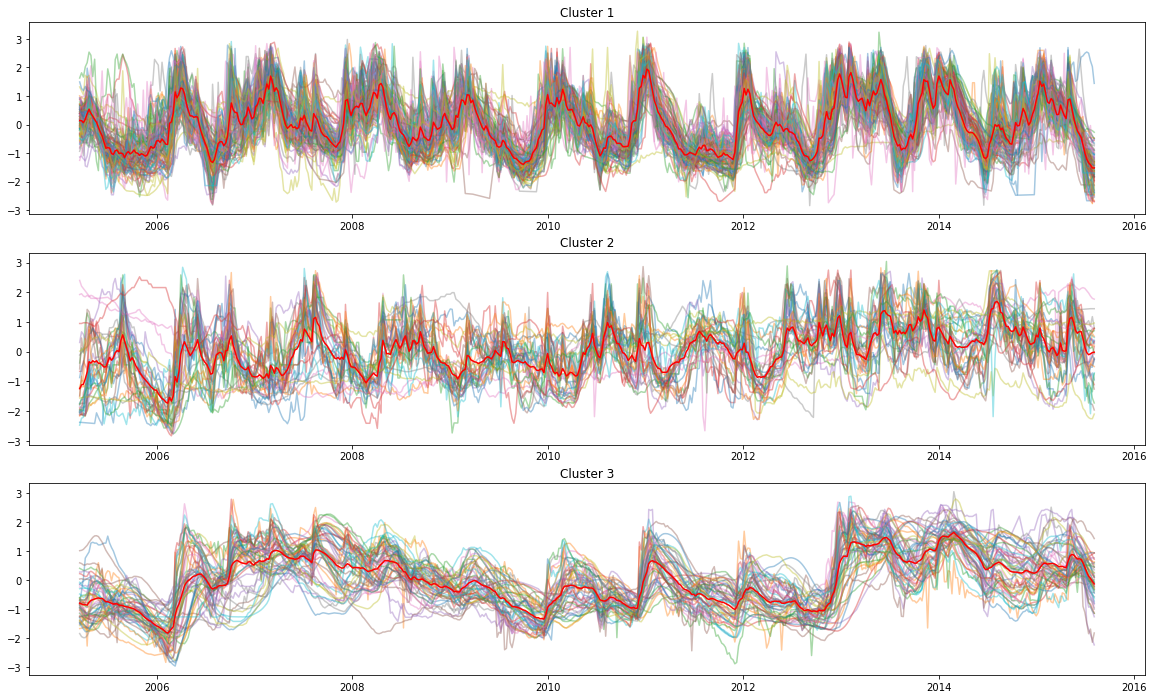

In [30]:
f_plot_clusters(data, cluster_table, cluster_centers)
#cluster_table.groupby("cluster").mean()

In [31]:
#f_plot_all(data, cluster_table, cluster_centers)

## Filtre des chroniques avec score insuffisant

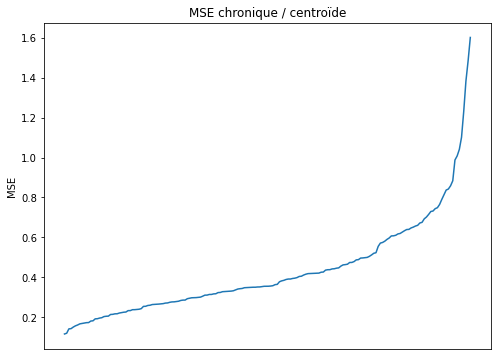

In [32]:
plt.figure(figsize=(8, 6))
ax = cluster_table["MSE"].sort_values().plot(title = "MSE chronique / centroïde")
ax.set_xlabel("")
ax.set_ylabel("MSE")
ax.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
plt.show()


Itération 1 : 11 chronique(s) éliminée(s).
Itération 2 : 4 chronique(s) éliminée(s).
Itération 3 : 0 chronique(s) éliminée(s).
Nombre total de chroniques éliminées : 15


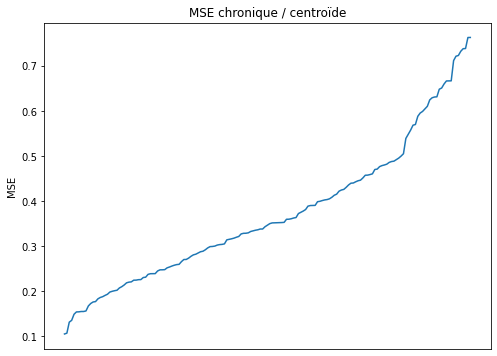

In [33]:
# nbre de chroniques sous le seuil
MSEmax = f_MSEmax(cluster_table)
cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0

nbre_elim_total = 0
nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()
nbre_elim_total += nbre_elim

iteration = 1
print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

data_opt = data.copy()

while nbre_elim != 0 :
    
    # Selection des clusters non zéro
    data_opt = data.copy().loc[:,cluster_table.loc[cluster_table.cluster != 0].index]
    
    # Nouveau clustering
    cluster_table, cluster_centers = f_clusters_fit(data_opt, nbre_clusters, n_init = 2000, max_iter = 500)

    # chroniques sous le seuil passées à cluster 0
    MSEmax = f_MSEmax(cluster_table)
    nbre_elim = cluster_table.loc[cluster_table.MSE > MSEmax, 'MSE'].count()   
    nbre_elim_total += nbre_elim
    

    cluster_table.loc[cluster_table.MSE > MSEmax, "cluster"] = 0
    iteration += 1
    print(f"Itération {iteration} : {nbre_elim} chronique(s) éliminée(s).")

    
for index, column in enumerate (cluster_centers.columns):
    cluster_centers.rename(columns={column : f"{index+1}"}, inplace=True)    
    
print(f"Nombre total de chroniques éliminées : {nbre_elim_total}")

plt.figure(figsize=(8, 6))
ax = cluster_table["MSE"].sort_values().plot(title = "MSE chronique / centroïde")
ax.set_xlabel("")
ax.set_ylabel("MSE")
ax.tick_params(left = True, right = False , labelleft = True ,
                labelbottom = False, bottom = False)
plt.show()


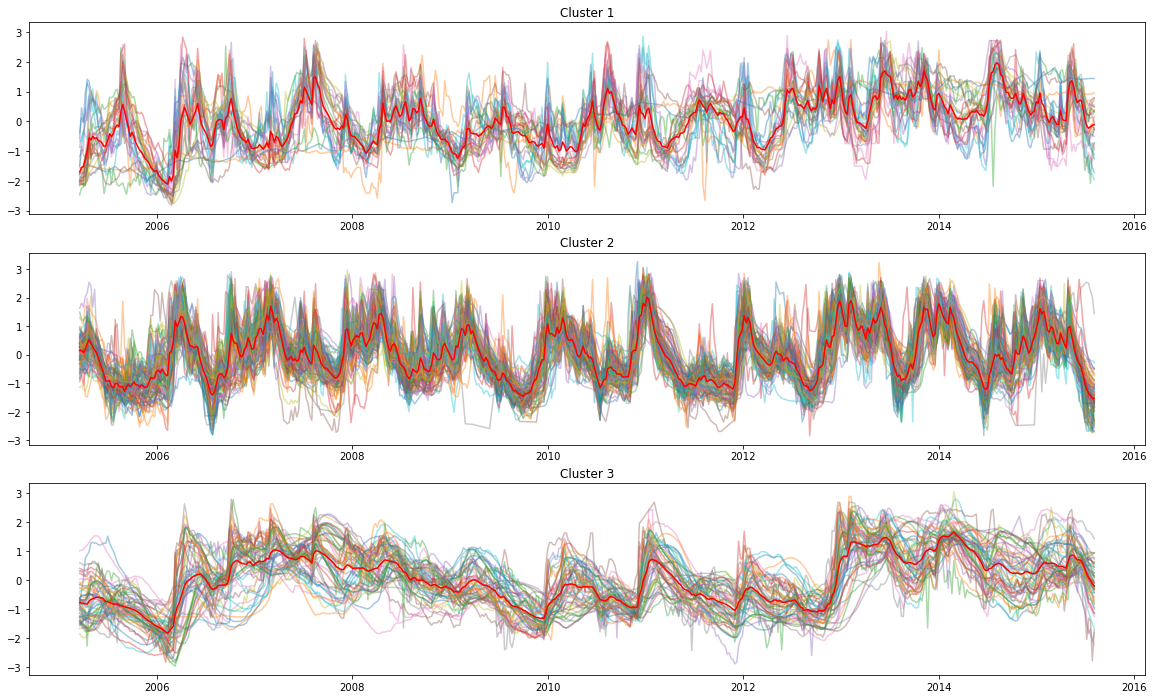

In [34]:
f_plot_clusters(data_opt, cluster_table, cluster_centers)

<AxesSubplot:xlabel='cluster', ylabel='count'>

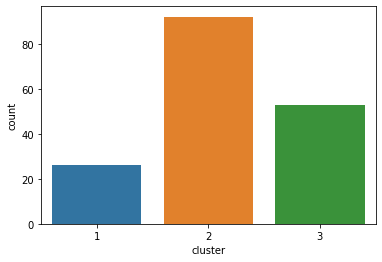

In [35]:
sns.countplot(data = cluster_table, x = "cluster")

## Renommage des noms de cluster

In [36]:
clusters =  list(range(1, nbre_clusters +1))
clusters_by_count = cluster_table.cluster.value_counts().index.to_list()

new_clusters = []

ch = "A"

for number in clusters_by_count :
    new_clusters.append(chr(ord(ch)+number-1))
    
# Renommage des clusters avec des lettres et par fréquence

# - Cluster table
cluster_table.replace(list(map(int, clusters)), new_clusters, inplace=True)

# - Cluster centers
dict_rename = dict(zip(map(str, clusters), new_clusters))
cluster_centers.rename(columns=dict_rename, inplace=True)

# Enregistrement des profils des clusters

In [39]:
cluster_centers.to_csv(f"./data/{region}_clusters.csv")

# Ajout à la bdd

In [40]:
# Nom de la table
table = "cluster_kmeans"

In [41]:
# Création de la table
requete = f"""
                    ALTER TABLE data_piezo
                    ADD {table} VARCHAR(6) DEFAULT NULL
                    """
f_requete_sql(requete)

Connexion réussie à SQLite
Erreur lors du mis à jour dans la table duplicate column name: cluster_kmeans


In [42]:
# Création de listes de nuéro de cluster avec le nom des piezos
# Ajout dans la bdd
for label in set(cluster_table.cluster):
    cluster = tuple(cluster_table.loc[cluster_table.cluster == label, 'cluster'].index.to_list())
    requete = f"""
        UPDATE data_piezo
        SET {table} = '{region}_{label}'
        WHERE code_bss IN {cluster}
        """
    f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée
Connexion réussie à SQLite
Connexion SQLite est fermée


## Suppresion colonne

requete = """
                    ALTER TABLE data_piezo
                    DROP cluster_kmeans
                    """
f_requete_sql(requete)

# Chronique caractéristique des clusters

In [43]:
cluster_table

cluster       MSE
code_bss                           
03423X0056_100          C  0.220672
02706X0074_S77-20       A  0.487706
04137X0009_C20          A  0.375093
04133X0006_30           A  0.604619
03786X0074_130          A  0.287519
...                   ...       ...
02663X0001_S            C  0.231018
03427X0545_PUITS        C  0.182934
BSS003MKHM_X            C  0.327054
BSS004AXXS_X            A  0.337943
03384X0037_PZ           C  0.270389

[171 rows x 2 columns]

In [44]:
# Recherche du code_bss avec la valeur MSE la plus faible
liste_top_bss = []
for cluster in cluster_table.cluster.unique() :
    liste_top_bss.append(cluster_table.loc[cluster_table.cluster == cluster].sort_values("MSE").index[0])
df_top = pd.DataFrame(liste_top_bss, cluster_table.cluster.unique(), columns=["code_bss"])

df_top = df_top.sort_index()

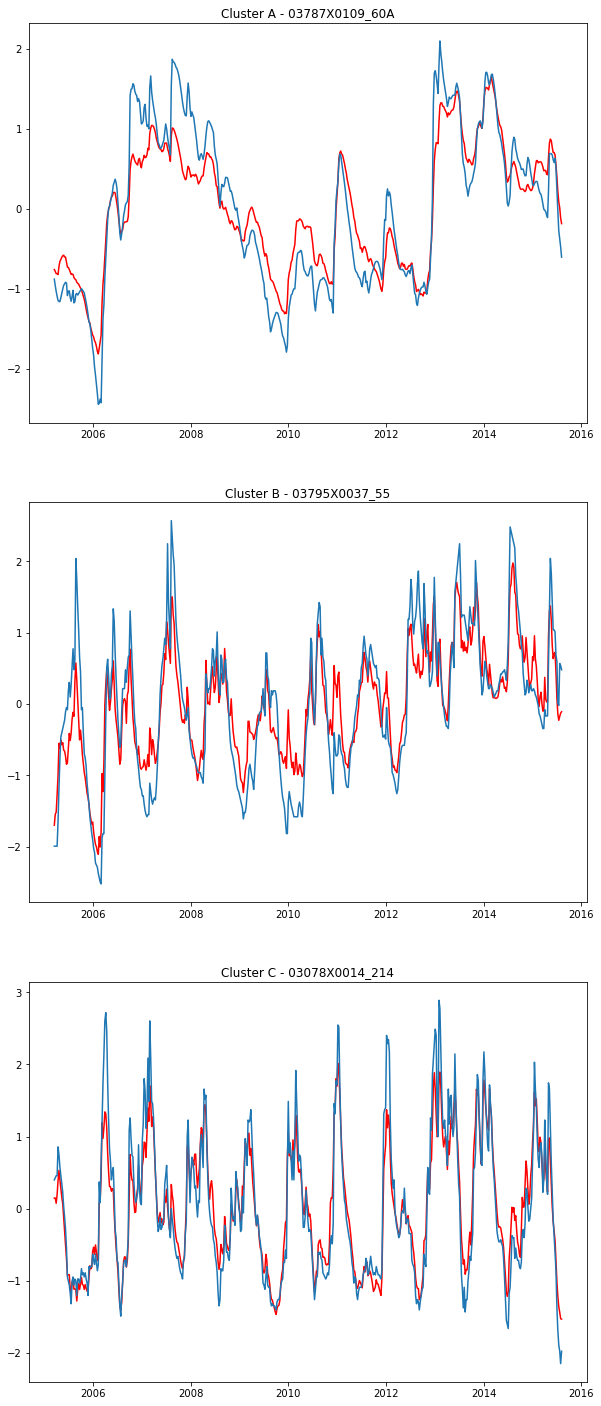

In [45]:
fig, axs = plt.subplots(len(df_top),1,figsize=(10,25))
for i in range (len(df_top)):
    cluster = df_top.index[i]
    bss = df_top.code_bss[cluster]
    axs[i].plot(cluster_centers.loc[:,cluster], 'red')
    axs[i].plot(data_opt.loc[:,bss])
    axs[i].set_title("Cluster "+ cluster + " - " + bss)    
                

## Ajout à la bdd

In [46]:
code_cluster = tuple(region + "_" +  df_top.index)
code_bss = tuple(df_top.code_bss.values)
tableau = list(np.stack((code_cluster,code_bss), axis=1))
for index, line in enumerate(tableau):
    tableau[index] = tuple(line)

In [47]:
# Création de la table
requete = f"""
            CREATE TABLE IF NOT EXISTS flagship_piezo (
            code_cluster VARCHAR(8) PRIMARY KEY ON CONFLICT IGNORE,
            code_bss VARCHAR(8)
            )
            """
f_requete_sql(requete)

Connexion réussie à SQLite
Connexion SQLite est fermée


[]

In [48]:
requete = f"INSERT INTO flagship_piezo (code_cluster, code_bss) VALUES (?,?)"

try:
    connexion = sqlite3.connect('../data/liste_piezos.db')
    curseur = connexion.cursor()
    print("Connexion réussie à SQLite")
    curseur.executemany(requete, tableau)
    connexion.commit()
    resultat = curseur.fetchall()
    curseur.close()
    connexion.close()
    print("Connexion SQLite est fermée")
except sqlite3.Error as error:
    print("Erreur lors du mis à jour dans la table : ", error)

Connexion réussie à SQLite
Connexion SQLite est fermée


### Suppression données region

# Création de la table
requete = f"""
            DELETE FROM flagship_piezo
            WHERE code_cluster LIKE '{region}%'
            """
f_requete_sql(requete)

#Suppression de la table
requete = f"""
            DROP TABLE flagship_piezo
            """
f_requete_sql(requete)